# Data Science Internship &mdash; Technical Assignment

You are asked to work on the data of a wastewater treatment plant.

First, I advise you to create a local environment using Python 3.11, and the packages you will find in `requirements.txt`.

With Conda, you can follow these steps (adapt for Python venv if needed):

```bash
conda create -n env_assignment python=3.11
conda activate env_assignment
pip install -r requirements.txt
```
___

## Goal

A colleague from the office just sent you an email, asking for your help. 

She is in charge of a wastewater treatment plant, and would like you to explore the possibility of developping a tool that forecasts the volume of wastewater entering the plant every hour.

The objective here is to see if it is feasable, in which case you will showcase your proof of concept to this colleague.

You are provided with the following dataset, as is:

In [132]:
import pandas as pd
import numpy as np
from utils.data import read_data

df = read_data()
df.head()

,wastewater volume,ww line 1,ww line 2,ww line 3,ww line 4,rainfall,temperature_2m,relative_humidity_2m,rain,precipitation
date,,,,,,,,,,
2018-07-01 01:00:00,1649.1,238.55,497.84,103.72,808.99,0.0,33.98,56.43,0.0,0.0
2018-07-01 02:00:00,1254.98,155.58,300.78,72.6,726.02,0.0,34.65,56.43,0.0,0.0
2018-07-01 03:00:00,622.3,114.09,186.69,31.12,290.41,0.0,34.24,60.2,0.0,0.0
2018-07-01 04:00:00,694.9,82.97,114.09,20.74,477.1,0.0,32.63,62.8,0.0,0.0
2018-07-01 05:00:00,186.69,62.23,93.35,31.12,0.0,0.0,32.01,62.09,0.0,0.0


_ww_ means _wastewater_, if you had not guessed ;)

### Variables

| Variable Name                        | Type       | Unit         | Description                                                                                      |
|---------------------------------------|------------|--------------|--------------------------------------------------------------------------------------------------|
| wastewater volume                    | timeseries | m³       | **Target variable**. Total hourly volume of water entering the WWTP.                             |
| ww line 1                   | timeseries | m³       | Hourly volume of wastewater (pipe 1).                               |
| ww line 2                   | timeseries | m³       | Hourly volume of wastewater (pipe 2).                                     |
| ww line 3                  | timeseries | m³       | Hourly volume of wastewater (pipe 3).                    |
| ww line 4      | timeseries | m³           | Hourly volume of wastewater (pipe 4).                                    |
| rainfall                              | timeseries | mm      | Hourly rainfall amount measured on site.                                                                          |
| temperature_2m                        | timeseries | °C           | Air temperature at 2 meters above ground.                                                        |
| relative_humidity_2m                  | timeseries | %            | Relative humidity at 2 meters above ground.                                                      |
| precipitation                         | timeseries | mm           | Total precipitation (rain, showers, snow) in the preceding hour.                                 |
| rain                                  | timeseries | mm           | Only liquid precipitation (rain, showers) in the preceding hour.                                 |


#### Explanations

* The **wastewater volume** is the sum of four main inlet flows: ww lines 1, 2, 3 and 4. They are different type of wastewater lines, coming from different places.
* **rainfall** is measured on site by a sensor. 
* The other weather variables (four last lines of the table above) are gathered from a weather provider for the broad area of the plant, and are considered predictions. You may use those, and **only those**, for your wastewater forecast. **rainfall** or any water volume are _unknown_ for tduring your forecast would be a data leak.
___


## Your Work Starts Here

<div style="border-radius:10px; padding: 15px; background-color: rgb(36, 117, 179); font-size:130%; text-align:left">

### **Introduction & approach summary**

The first long task was to understand the dataset and the different relationships between the variables (very complex between correlation, autocorrelation, and multiple seasonal dependencies). 

My work was organized by going back and forth between tests and research, while also leaving time between sessions to take a step back from the problem and try to better understand its depth. 

After analyzing the data, I chose to test a simple initial model, which would give me some initial feedback on my analyses, then I tried to improve it using the results and other ideas about bias that came to me later. 

Finally, I wanted to spend some time looking for a model that would better match the complexity of the problem, namely a multivariate variable to predict (the sum of four variables with distinct temporal behaviors). While researching deep learning, I came across an article that addressed this type of multi-scale problem and also provided an example of implementation. In the end, this was the model that seemed to work best.

Below is a summary of the analyses carried out.


<a id="contents_tabel"></a>    
<div style="border-radius:10px; padding: 15px; background-color: rgb(36, 117, 179); font-size:130%; text-align:left">

<h2 align="left"><font>Table of Contents:</font></h2>
    
* [Part I - Charging the librairies](#librairies)
* [Part II - Initial Data Analysis](#initial_analysis) 
    - [II.1. Dataset Overview](#overview) 
    - [II.2. Summary Statistics](#statistics) 
    - [II.3. First vizualization of the data](#vizualization)
    - [II.4. Checking Correlation and Auto Correlation](#Correlation)
        - [Autocorrelation](#autocorrelation)
        - [Correlation](#correlation)
* [Part III - Data Cleaning & Transformation](#data_cleaning)
    - [III.1. Handling Missing Values](#missing_values)
    - [III.2. Handling Duplicates](#duplicates)
    - [III.3. Handling Outliers](#outliers)
* [Part IV - A First Simple Model, LightGBM](#LightGBM)
    - [IV.1. Feature Enginerring for LightGBM](#FE_LGBM)
        - [Part IV.1.A A New DataFrame](#new_dataframe) 
        - [Part IV.1.B Lags & rolling_means](#lags)
    - [Part IV.2 Implementing the model](#LGBM)
        - [Part IV.2.A Defining the target and feature selection](#target)
        - [Part IV.2.B Splitting the Data](#split)
        - [Part IV.1.C Finding the hyperparameters](#hyperparamters) 
        - [Part IV.1.D Model and Evaluation](#model) 
        - [Part IV.1.E Feature Importance](#feature)
* [PART V - Improving the LightGBM](#v2)
    - [Part V.1 Feature Enginerring for LightGBM v.2](#fe_2)
        - [Part V.1.A Target and lags](#lags2)
        - [Part V.1.B Autocorrelation based features](correlation2) 
        - [Part V.1.C Cyclical features](#cyclical) 
    - [Part V.2 Implementing the model](#model2)
        - [Part V.2.A Train/test split by shuffled 7-day blocks](#split2)
        - [Part V.2.B Splitting the Data](#kmeans_model)
        - [Part V.2.C Finding the hyperparameters](#evaluation)
        - [Part V.2.D Model and Evaluation](#evalutaion2)
* [PART VI - Testing a more advanced model using Deep Learning - Ts2Vec](#ts2vec)
    - [Part VI.1 Preparing the Data](#cluster_distributuion) 
    - [Part VI.2 Implementing the model](#evaluations_metrics)
        - [Part VI.2.A Training ts2vec](#profiling)
        - [Part VI.2.B Linear regression on the encoded train set](#radar_chart)
        - [Part VI.2.C Evaluting the model](#model3)
        - [Part VI.2.D Recreating the wastewater volume feature to plot the results](#plot)

<a id="librairies"></a>

# <p style="color:#E71B24; font-family:'Futura', 'Century Gothic', 'Verdana', sans-serif; font-weight:600; letter-spacing:0.5px; text-align:center;">PART I - Charging the libraries</p>
⬆️ [Tabel of Contents](#contents_tabel)


In [133]:
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from lightgbm import LGBMRegressor
import optuna
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from pandas.plotting import autocorrelation_plot
from ts2vec import TS2Vec
from sklearn.linear_model import LinearRegression
import torch

<p style="color:red"> xx mettre des commentaires expliquant à quoi servent chacune des librairies </p>

<a id="initial_analysis"></a>
# <p style="color:#E71B24; font-family:'Futura', 'Century Gothic', 'Verdana', sans-serif; font-weight:600; letter-spacing:0.5px; text-align:center;">PART II - First analysis on the data</p>

<a id="overview"></a>
## <p style="color: rgb(300, 110, 110); font-family:'Futura', 'Century Gothic', 'Verdana', sans-serif; font-weight:600; letter-spacing:0.5px;">  Part II.1 Dataset Overview</p>


In [134]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 25727 entries, 2018-07-01 01:00:00 to 2021-06-06 23:00:00
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   wastewater volume     25720 non-null  object 
 1   ww line 1             25727 non-null  object 
 2   ww line 2             25727 non-null  object 
 3   ww line 3             25727 non-null  object 
 4   ww line 4             25720 non-null  object 
 5   rainfall              25727 non-null  float64
 6   temperature_2m        25727 non-null  object 
 7   relative_humidity_2m  25719 non-null  object 
 8   rain                  25727 non-null  object 
 9   precipitation         25727 non-null  object 
dtypes: float64(1), object(9)
memory usage: 2.2+ MB


<div style="border-radius:10px; padding: 15px; background-color:rgb(36, 117, 179); font-size:120%; text-align:left">

**Inferences :** 

- The dataset contains 25727 entries, covering the 2018-2021 period and each entry corresponding to an hour of day during these 3 years. It is important to check if there are any gaps in the period.


- All the columns are of object type, except the rainfall one which is a float type. As they actually are all numbers, we will change these types to float, which will be easier to deal with.
Some columns (WW volume, WW line 4 and relative_humidity_2m) contain missing values which we will address later. 

In [135]:
# Checking for eventual gaps in the time series
time_diffs = df.index.to_series().diff()
gaps = time_diffs[time_diffs > pd.Timedelta(hours=1)]

if gaps.empty:
    print("No gaps found in the time series.")

No gaps found in the time series.


In [136]:
# Changing the dtypes of the columns to float type, taking care of some eventual commas as decimal separators
for col in df.columns:
    if col != "date":
        df[col] = (
            df[col]
            .astype(str)                  # converting to string first
            .str.replace(',', '.', regex=False)  # replacing commas with dots
            .astype(float)                # converting to float
        )

In [137]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 25727 entries, 2018-07-01 01:00:00 to 2021-06-06 23:00:00
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   wastewater volume     25720 non-null  float64
 1   ww line 1             25727 non-null  float64
 2   ww line 2             25727 non-null  float64
 3   ww line 3             25727 non-null  float64
 4   ww line 4             25720 non-null  float64
 5   rainfall              25727 non-null  float64
 6   temperature_2m        25727 non-null  float64
 7   relative_humidity_2m  25719 non-null  float64
 8   rain                  25727 non-null  float64
 9   precipitation         25727 non-null  float64
dtypes: float64(10)
memory usage: 2.2 MB


<a id="statistics"></a>
## <p style="color: rgb(300, 110, 110); font-family:'Futura', 'Century Gothic', 'Verdana', sans-serif; font-weight:600; letter-spacing:0.5px;">Part II.2 Some First Statistics on the Data

In [138]:
df.describe()

,wastewater volume,ww line 1,ww line 2,ww line 3,ww line 4,rainfall,temperature_2m,relative_humidity_2m,rain,precipitation
count,25720.000000,25727.000000,25727.000000,25727.000000,25720.000000,25727.000000,25727.000000,25719.000000,25727.000000,25727.000000
mean,1535.162851,303.458319,458.883286,117.924665,654.388014,0.192325,16.623137,73.740936,0.191677,0.194145
std,955.505071,556.530630,258.965344,59.530361,271.357269,1.201742,9.091032,18.538776,0.962203,0.966178
min,134.830000,31.120000,62.230000,0.000000,0.000000,0.000000,-6.520000,10.060000,0.000000,0.000000
25%,1016.430000,165.950000,321.520000,72.600000,477.100000,0.000000,9.290000,60.560000,0.000000,0.000000
50%,1535.010000,207.430000,435.610000,114.090000,777.880000,0.000000,16.920000,76.790000,0.000000,0.000000
75%,1877.280000,269.660000,611.930000,155.580000,819.360000,0.000000,24.330000,89.300000,0.000000,0.000000
max,14312.950000,5372.540000,4273.140000,767.510000,2115.830000,34.230000,37.710000,103.720000,27.690000,27.690000


<div style="border-radius:10px; padding: 15px; background-color:rgb(36, 117, 179); font-size:120%; text-align:left">

#### Inferences :

**WW Volume :**  
- The mean ww volume entering the WWTP is 1535 with a large std of 955.5.  
- It has a wide range with a maximum at 14312, much higher than the 75% quartile, and which we will thus have to further investigate.  
- The 7 seven missing values will also be treated. 

**WW lines 1,2,3,4:**  
- Same inferences than the WW Volume's column.  
- The minimum values are not below 0, so there are no lower outliers, but the maximum values will need to be investigated.  

**Rainfall:**  
- Given the 25%, 50% and 75% quartiles, we can observe that the entries of this column are mainly zero.   
- The maximal value once again seems very big, but not physically impossible during a particularly stormy day.

**temperature_2m and relative_humidity_2m:**  
- These columns do not seem to have strange values (physically coherent), excepted for de 103% of relative humidity. It can however just a sensor's mistake due to noise as it is not that far from a coherent value. 
- The missing values of the relative humidity column will have to be addressed.

**rain and precipitation:**
- These columns seem to be close to identical, which is coherent considering they only differ on the snow counting. It will be further investigated wether it is useful to keep the two columns while applying the models. 
- We can also observe that the mean is very close to the rainfall column, which seems to indicate that the weather predications are rather accurate on average. 





<a id="vizualization"></a>
## <p style="color: rgb(300, 110, 110); font-family:'Futura', 'Century Gothic', 'Verdana', sans-serif; font-weight:600; letter-spacing:0.5px;"> Part II.3 First vizualization of the data

<div style="border-radius:10px; padding: 15px; background-color:rgb(36, 117, 179); font-size:120%; text-align:left">In this section, we will take a first look at the data by testing different views (hourly, daily, weekly, montly). The goal is to have a first idea of the variations of the wastewater volume, its trends, and eventual seasonality. 

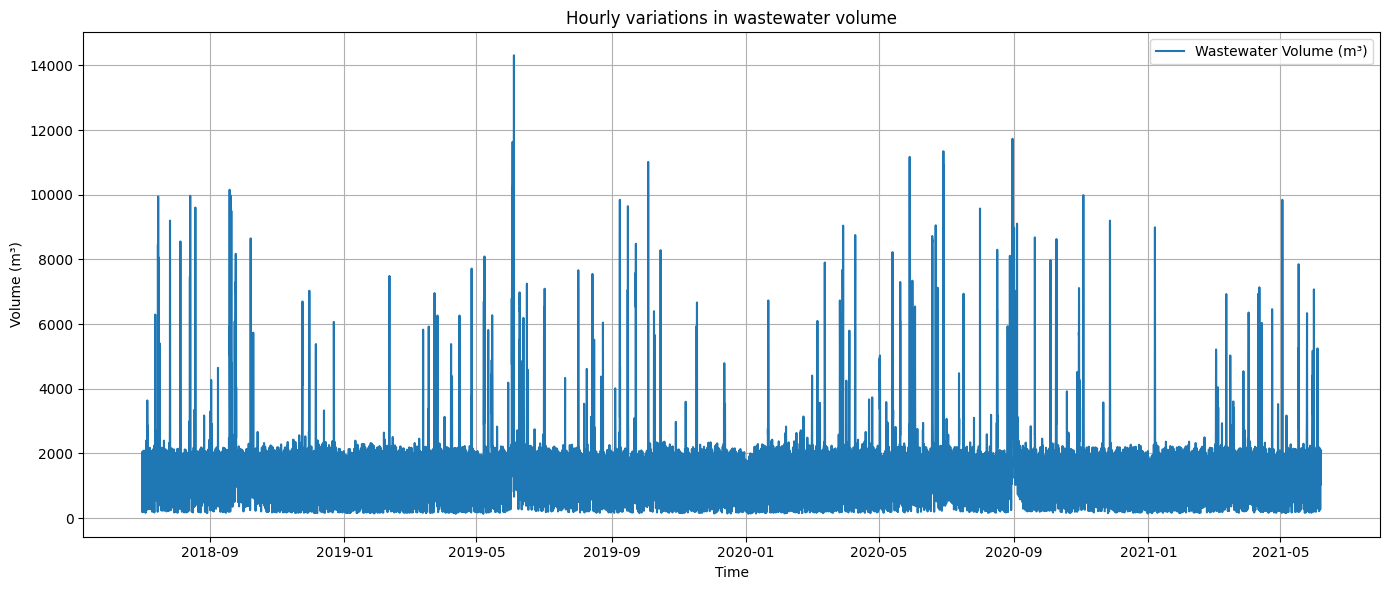

In [139]:
# Visualize the wastewater volume over the entire time period

plt.figure(figsize=(14, 6))
plt.plot(df.index, df['wastewater volume'], label='Wastewater Volume (m³)', linewidth=1.5)
plt.title('Hourly variations in wastewater volume')
plt.xlabel('Time')
plt.ylabel('Volume (m³)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

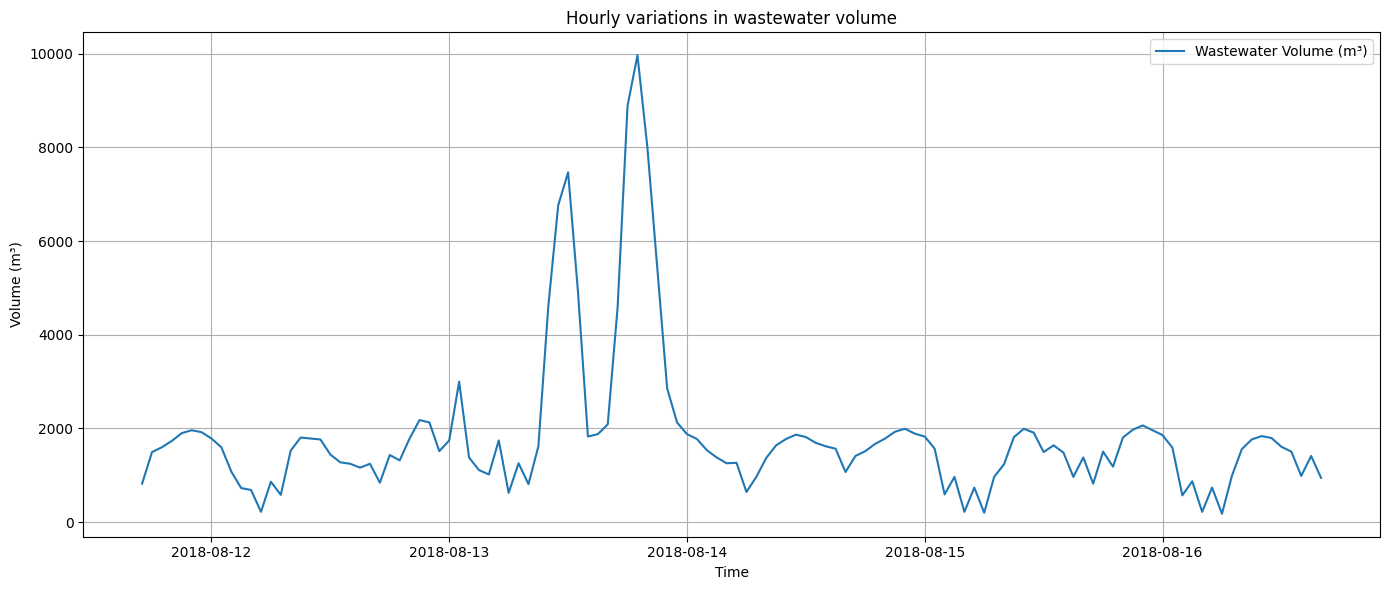

In [140]:
# Visualize the wastewater volume over Nadays days for better clarity
i=1000
Ndays=5
plt.figure(figsize=(14, 6))
plt.plot(df.index[i:24*Ndays+i], df['wastewater volume'][i:24*Ndays+i], label='Wastewater Volume (m³)', linewidth=1.5)
plt.title('Hourly variations in wastewater volume')
plt.xlabel('Time')
plt.ylabel('Volume (m³)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

<div style="border-radius:10px; padding: 15px; background-color:rgb(36, 117, 179); font-size:120%; text-align:left">

#### Inferences :

**Significant variability**  
Wastewater volume varies a little from hour to hour, with frequent peaks and periods of low activity.
Peaks can exceed 10,000 m³, while troughs often fall below 2,000 m³.

**Apparent seasonality**  
Repeating patterns are observed on regular cycles, suggesting daily or weekly seasonality.
Peaks seem to occur at similar times of day, probably linked to human activity (e.g., morning and evening).

**Long-term trend**  
There is no clear upward or downward trend over the entire period, but seasonal variations are noted

**Outliers**  
Some values are well above the average, which may indicate exceptional events (heavy rainfall, industrial incidents, or errors).


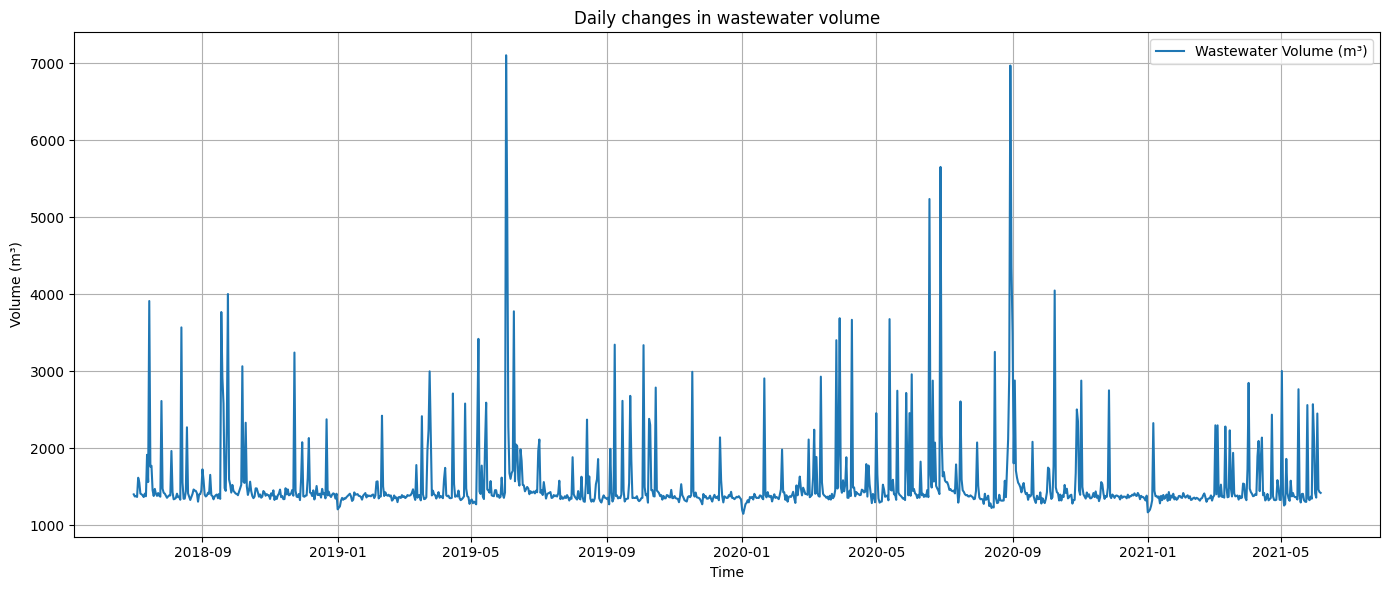

In [141]:
df_mean = df.resample('d').mean()

plt.figure(figsize=(14, 6))
plt.plot(df_mean.index, df_mean['wastewater volume'], label='Wastewater Volume (m³)', linewidth=1.5)
plt.title('Daily changes in wastewater volume')
plt.xlabel('Time')
plt.ylabel('Volume (m³)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

<div style="border-radius:10px; padding: 15px; background-color:rgb(36, 117, 179); font-size:120%; text-align:left">
Daily variability

The average daily volume of wastewater generally varies between 1,000 m³ and 4,000 m³, with peaks of up to 7,000 m³.
Peaks are less frequent and smaller than in the hourly graph, but remain significant.

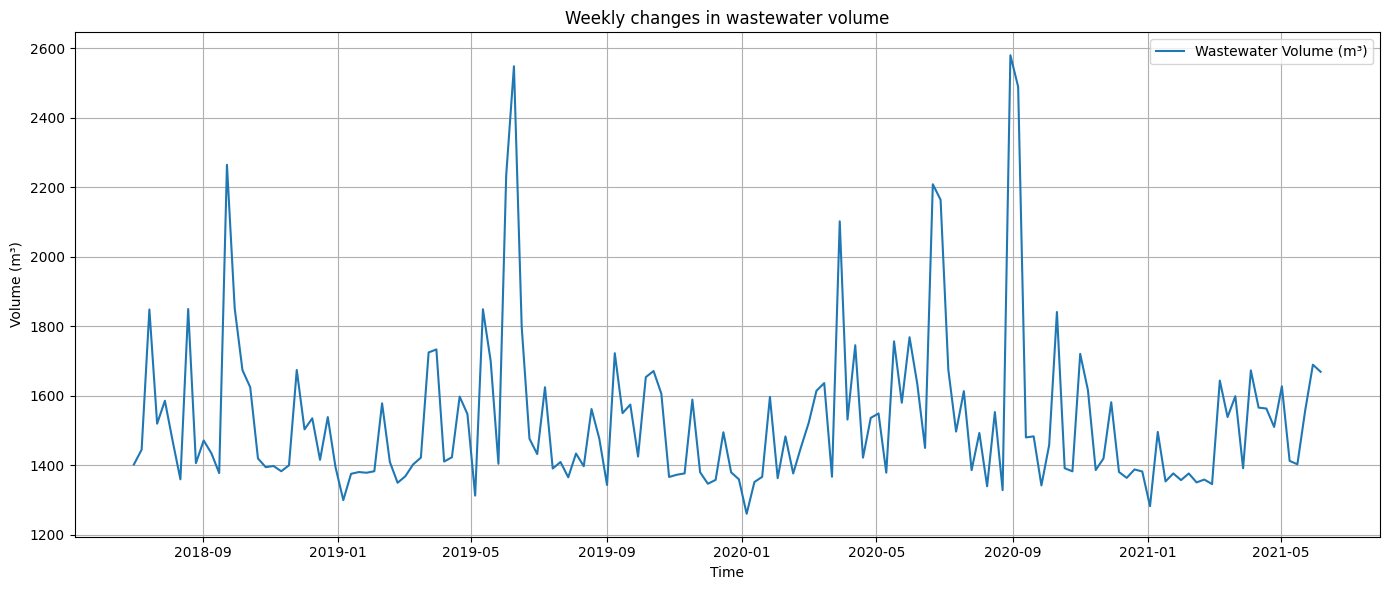

In [142]:
df_mean = df.resample('W').mean()

plt.figure(figsize=(14, 6))
plt.plot(df_mean.index, df_mean['wastewater volume'], label='Wastewater Volume (m³)', linewidth=1.5)
plt.title('Weekly changes in wastewater volume')
plt.xlabel('Time')
plt.ylabel('Volume (m³)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

<div style="border-radius:10px; padding: 15px; background-color:rgb(36, 117, 179); font-size:120%; text-align:left">
Weekly variability  
 
Here we can see that the peaks are much less significant (maximum at 2600), which shows that large variations are very occasional (and almost entirely smoothed out over a week).

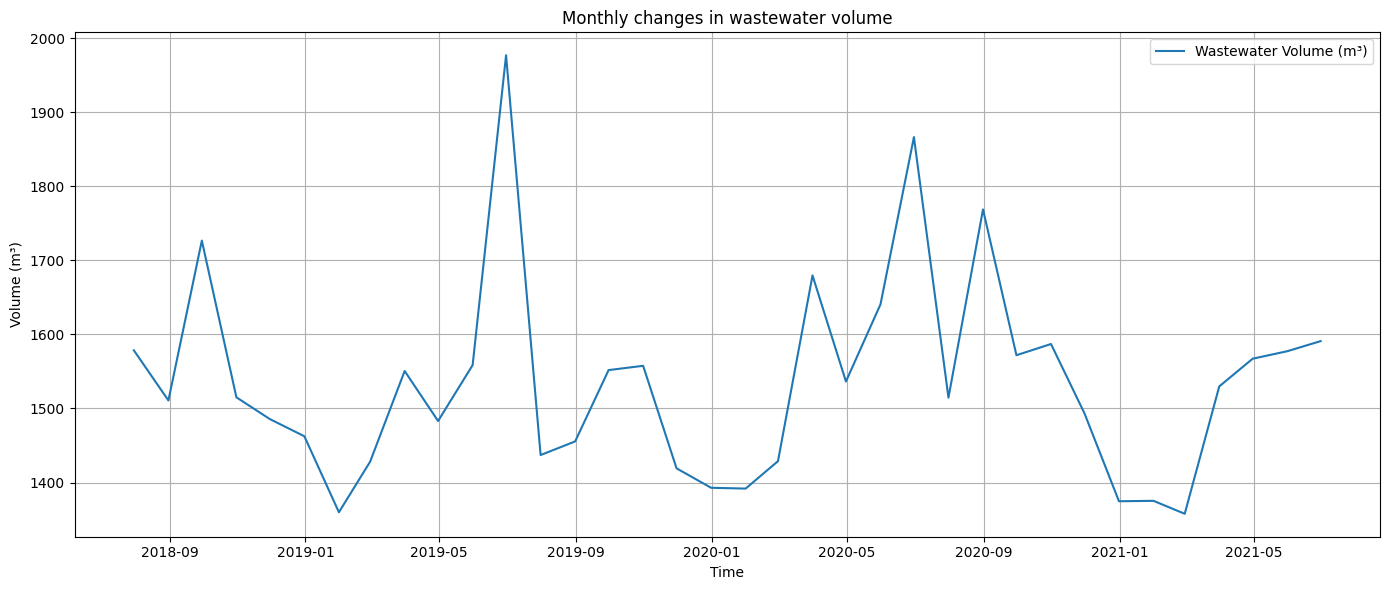

In [143]:
df_mean = df.resample('M').mean()

plt.figure(figsize=(14, 6))
plt.plot(df_mean.index, df_mean['wastewater volume'], label='Wastewater Volume (m³)', linewidth=1.5)
plt.title('Monthly changes in wastewater volume')
plt.xlabel('Time')
plt.ylabel('Volume (m³)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

<div style="border-radius:10px; padding: 15px; background-color:rgb(36, 117, 179); font-size:120%; text-align:left">There appears to be annual seasonality, with recurring peaks at certain times of the year.
For example, peaks are observed in summer (June-September) and lows in winter (December-January). 

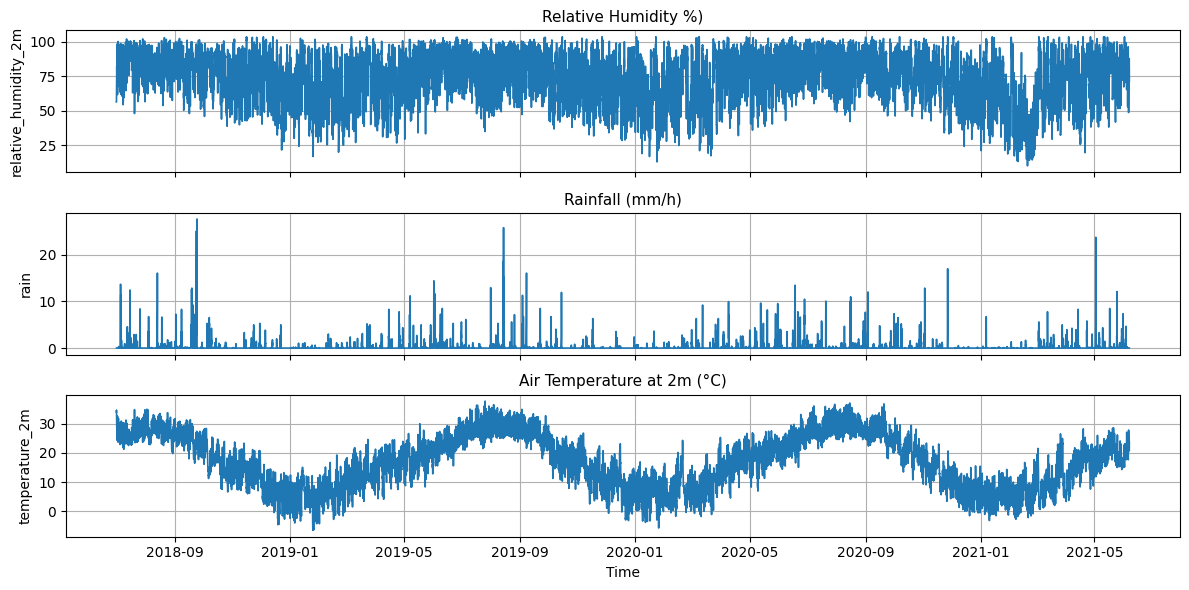

In [144]:
variables = ['relative_humidity_2m', 'rain', 'temperature_2m']
titles = [
    'Relative Humidity %)',
    'Rainfall (mm/h)',
    'Air Temperature at 2m (°C)'
]

fig, axes = plt.subplots(len(variables), 1, figsize=(12, 6), sharex=True)

for i, var in enumerate(variables):
    axes[i].plot(df.index, df[var], linewidth=1.2, color='tab:blue')
    axes[i].set_title(titles[i], fontsize=11)
    axes[i].grid(True)
    axes[i].set_ylabel(var)

axes[-1].set_xlabel('Time')
plt.tight_layout()
plt.show()


<div style="border-radius:10px; padding: 15px; background-color:rgb(36, 117, 179); font-size:120%; text-align:left">
Here we can see that the three variables have variations that appear to be seasonal, which was excepted for weather features

Their peaks also appear to be coordinated, which could indicate a correlation between them, which then again seems logical

<a id="Correlation"></a>
## <p style="color: rgb(300, 110, 110); font-family:'Futura', 'Century Gothic', 'Verdana', sans-serif; font-weight:600; letter-spacing:0.5px;"> Part II.4 Checking Correlation and Auto Correlation

<div style="border-radius:10px; padding: 15px; background-color:rgb(36, 117, 179); font-size:120%; text-align:left">

In this setion we continue to investigate the data set. We take a better look at the temporal dependencies within our dataset by examining the Autocorrelation Function (ACF) and the Partial Autocorrelation Function (PACF).


- **ATF :** measures how a time-series variable is correlated with its own past values across different lags. It helps reveal overall patterns such as persistence or repeating cycles.

- **PACF :** isolates the direct relationship between a variable and its past values at a specific lag, removing the effects of the intermediate lags. It is especially useful for identifying the appropriate number of autoregressive terms in time-series models.

 These tools help us identify patterns such as persistence, seasonality, and lagged relationships, which are essential for understanding the underlying dynamics of each variable and for guiding subsequent time-series modeling steps.

<a id="autocorrelation"></a>
### <p style="color: rgb(250, 150, 150); font-family:'Futura', 'Century Gothic', 'Verdana', sans-serif; font-weight:600; letter-spacing:0.5px;"> II.4.A Autocorrelation

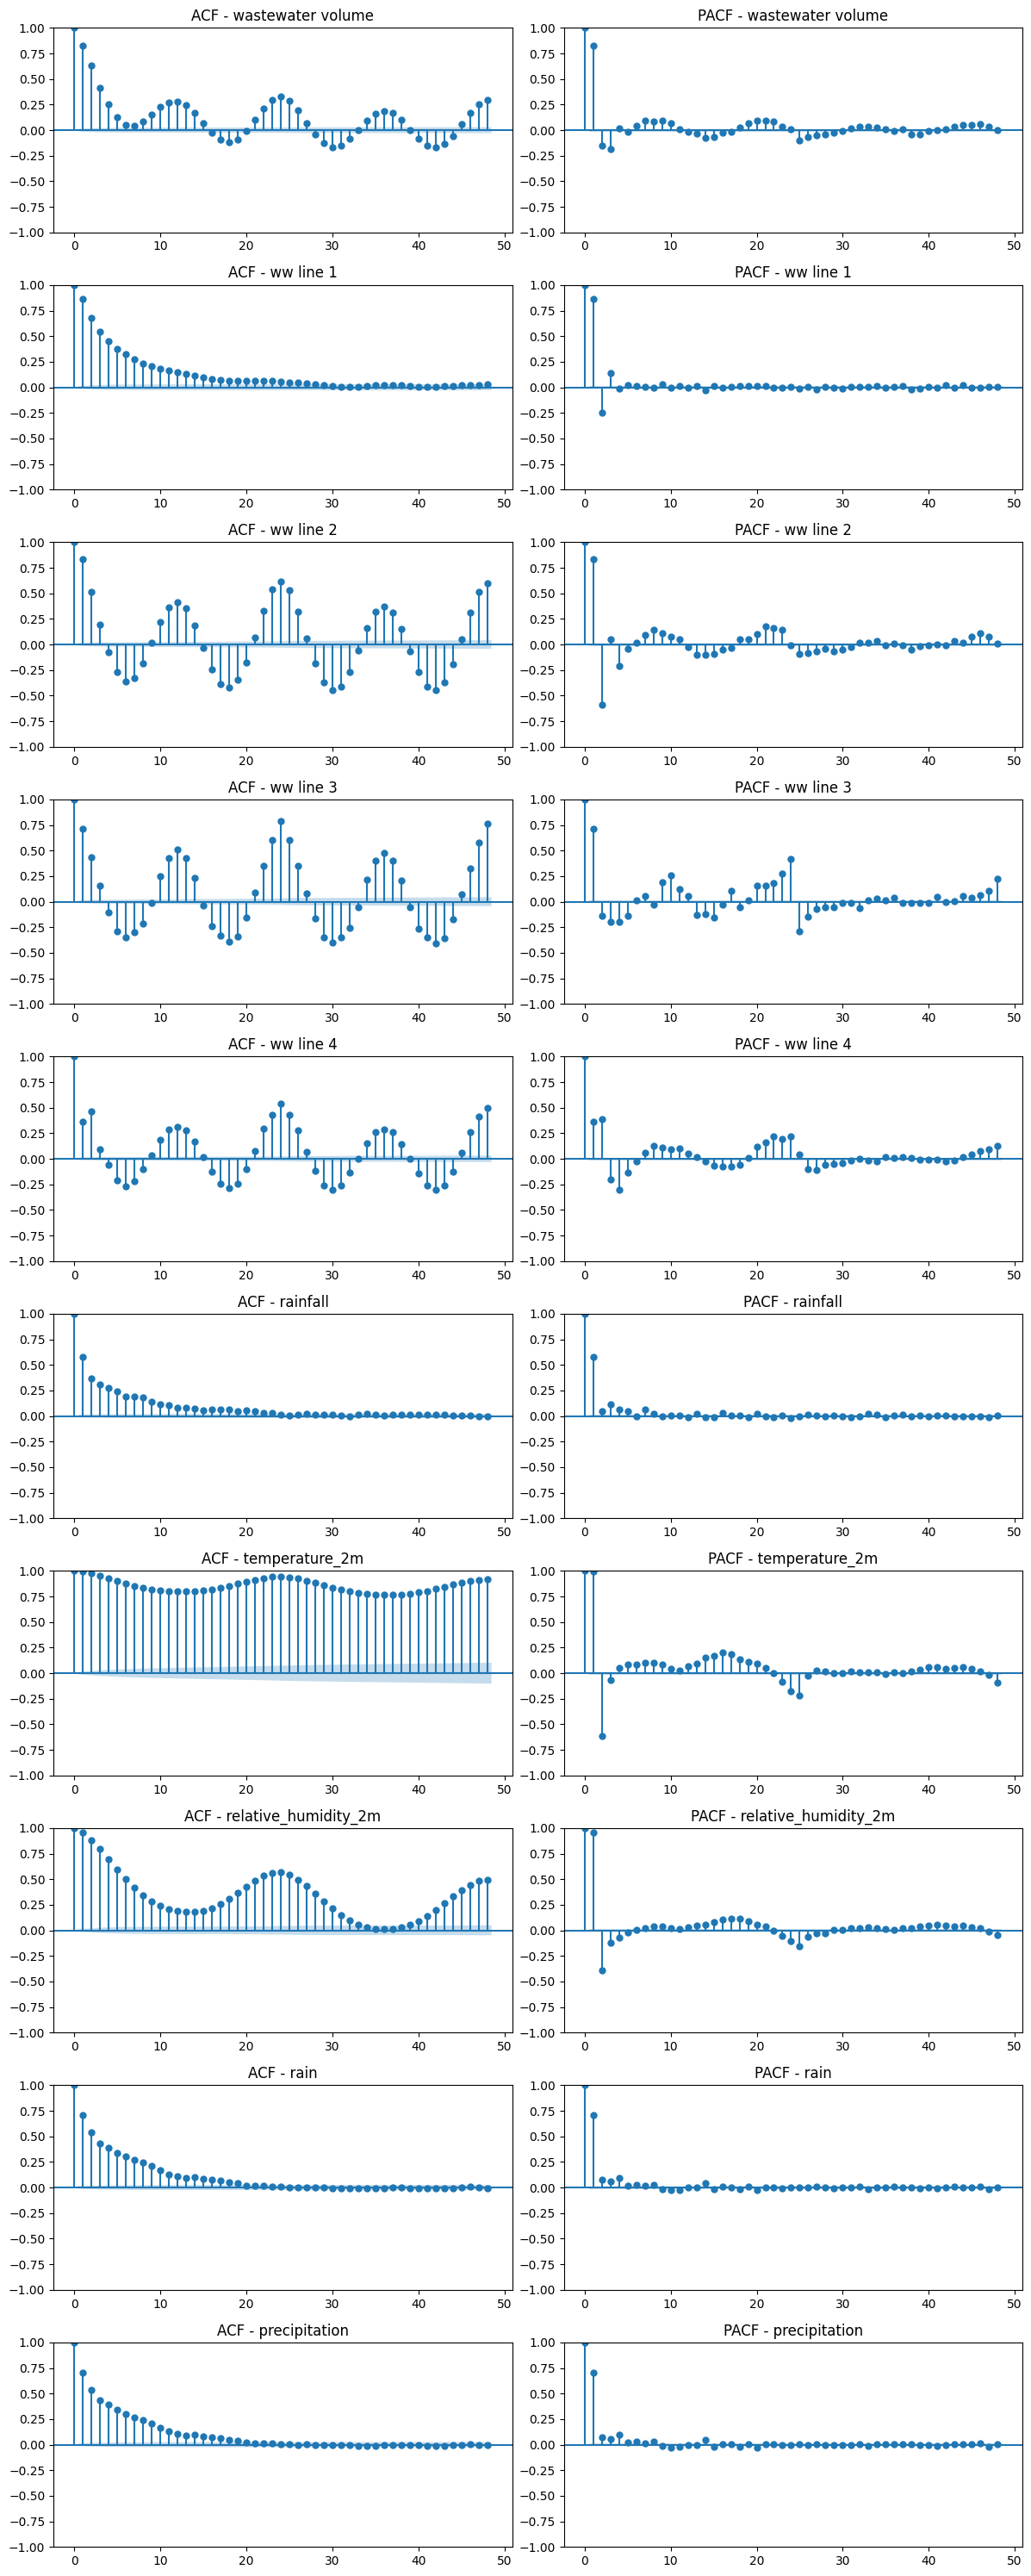

In [145]:
variables = df.columns.tolist()
n_vars = len(variables)
fig, axes = plt.subplots(n_vars, 2, figsize=(12, n_vars * 3))  # 3 inches height per variable

for i, var in enumerate(variables):
    plot_acf(df[var].dropna(), ax=axes[i, 0], lags=48, title=f"ACF - {var}")
    plot_pacf(df[var].dropna(), ax=axes[i, 1], lags=48, title=f"PACF - {var}")

plt.tight_layout()
plt.show()


<div style="border-radius:10px; padding: 15px; background-color:rgb(36, 117, 179); font-size:120%; text-align:left">

**ACF**

- The ww lines 2-3 see their ACF decrease slightly and then fluctuate. This therefore shows cyclical autocorrelation, with high peaks occuring at lag 12,24 and 48, while low peaks occur at lags 6,18,30 etc
- The rain, rainfall, precipation and ww line have a slowly deacreasing ACF, suggesting that they are influenced by the 10-15 values coming before but much 
less by the further ones. 

**PCF**

- All the variables have a first (and sometimes second) big peak. 
- The values of the other lags are close to zero, indicating that short-term dependence is mainly captured by the first lag.


<a id="correlation"></a>
### <p style="color: rgb(250, 150, 150); font-family:'Futura', 'Century Gothic', 'Verdana', sans-serif; font-weight:600; letter-spacing:0.5px;"> II.4.B Autocorrelation

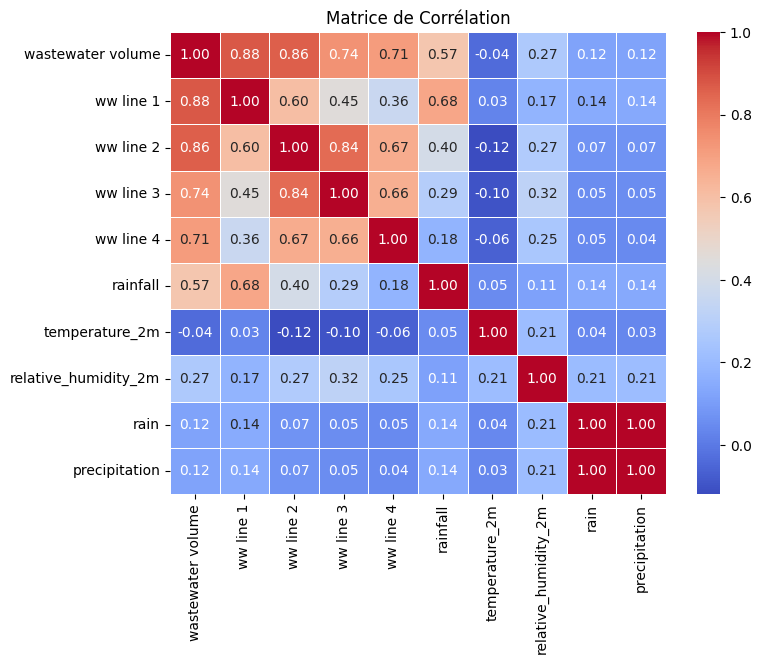

In [146]:
#Chacking correlaion

correlation_matrix = df.corr()

plt.figure(figsize=(8,6))  # taille de la figure
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt=".2f")
plt.title("Matrice de Corrélation")
plt.show()


<div style="border-radius:10px; padding: 15px; background-color:rgb(36, 117, 179); font-size:120%; text-align:left">

#### Inferences 

**Wastewater Volume:**

Strong correlations with the four ww lines 1 as expected as it is thei sum.
Positive correlation with rainfall (0.58), suggesting that rainfall impacts wastewater volume the most of the weather variables.



**Wastewater Lines:**

ww line 1 and ww line 2 are highly correlated (0.60), indicating a potential shared influence or similar behavior.
ww line 3 and ww line 4 also show moderate correlations with other wastewater lines.



**Meteorological Variables:**

Rainfall shows a moderate positive correlation with wastewater volume (0.58) and various wastewater lines.
Temperature_2m and relative_humidity_2m have low or negligible correlations with wastewater volume, indicating a weaker influence.
Rain and precipitation are perfectly correlated (1.00), as expected, since they almost represent the same thing. 


It could be interesting to see if other correlations appear with a daily average, as some variables seem to have daily autocorrelations (as seen just before).

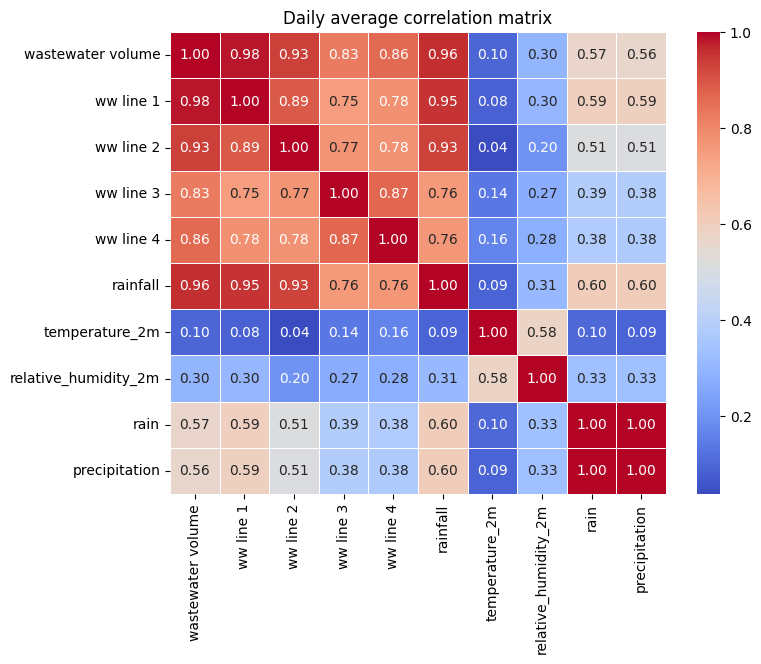

In [147]:
#checking daily correlation

daily_df = df.resample('D').mean()
daily_correlation_matrix = daily_df.corr()

plt.figure(figsize=(8,6))  # taille de la figure
sns.heatmap(daily_correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt=".2f")
plt.title("Daily average correlation matrix")
plt.show()

<div style="border-radius:10px; padding: 15px; background-color:rgb(36, 117, 179); font-size:120%; text-align:left">

#### Inferences


**Wastewater Volume:**

Extremely high positive correlation with ww line 1 (0.99) and ww line 2 (0.93), indicating that these lines are primary contributors to the overall wastewater volume.
Strong positive correlation with ww line 4 (0.86) and ww line 3 (0.82).
High positive correlation with rainfall (0.96), suggesting a significant impact of rainfall on wastewater volume.



**Wastewater Lines:**

ww line 1 and ww line 2 are highly correlated (0.89), indicating similar behavior or shared influences.
ww line 3 and ww line 4 also show strong correlations with other wastewater lines, though slightly less than ww line 1 and ww line 2.



**Meteorological Variables:**

Rainfall shows a very high positive correlation with wastewater volume (0.96) and strong correlations with various wastewater lines, indicating its significant influence.
Rain and precipitation are perfectly correlated (1.00), as they likely represent similar measurements.
Temperature_2m and relative_humidity_2m have low correlations with wastewater volume, indicating a weaker influence.

<a id="data_cleaning"></a>
# <p style="color:#E71B24; font-family:'Futura', 'Century Gothic', 'Verdana', sans-serif; font-weight:600; letter-spacing:0.5px; text-align:center;">PART III - Data Cleaning & Transformation</p>

<div style="border-radius:10px; padding: 15px; background-color:rgb(36, 117, 179); font-size:120%; text-align:left">

This step encompasses a comprehensive cleaning and transformation process to refine the dataset. It includes addressing missing values, eliminating duplicate entries, correcting anomalies, and other necessary adjustments to prepare the data for modeling.

<a id="missing_values"></a>
## <p style="color: rgb(300, 110, 110); font-family:'Futura', 'Century Gothic', 'Verdana', sans-serif; font-weight:600; letter-spacing:0.5px;"> Part III.1 Handling Missing Values 

In [148]:
#Visualising the missing values 
df[df.isna().any(axis=1)]

,wastewater volume,ww line 1,ww line 2,ww line 3,ww line 4,rainfall,temperature_2m,relative_humidity_2m,rain,precipitation
date,,,,,,,,,,
2018-11-05 10:00:00,NaN,248.92,622.30,165.95,NaN,0.0,10.95,68.88,0.00,0.00
2018-12-18 17:00:00,1182.37,207.43,321.52,72.60,580.82,0.0,-2.63,NaN,0.00,0.00
2018-12-31 22:00:00,1887.65,228.18,643.05,165.95,850.48,0.0,-1.75,NaN,0.00,0.00
2019-01-05 18:00:00,1503.90,186.69,363.01,124.46,829.74,0.0,-4.03,NaN,0.00,0.00
2019-01-25 11:00:00,1856.53,217.81,632.67,155.58,850.48,0.0,-3.05,NaN,0.00,0.00
2019-02-15 18:00:00,1120.14,176.32,373.38,134.83,435.61,0.0,-1.60,NaN,0.00,0.00
2019-02-17 17:00:00,943.82,186.69,331.89,72.60,352.64,0.0,-1.13,NaN,0.00,0.00
2019-10-08 01:00:00,NaN,217.81,404.50,114.09,NaN,0.0,19.82,52.45,0.00,0.00
2019-12-23 17:00:00,840.11,197.06,321.52,82.97,238.55,0.0,-1.03,NaN,0.00,0.00


<div style="border-radius:10px; padding: 15px; background-color:rgb(36, 117, 179); font-size:120%; text-align:left">

- We can see that the rows where the wastewater volume is missing are the same as the ones where the data on the ww line 4 is missing too. We thus can't just sum or subtract the other values to get the one missing. We can see however that the missing values don't follow each other. 

- The missing values in the humidity column are also isolated. 

Depending on the model used in the end, even if the missing values only represent 0,0003% of the dataset, deleting them could confuse the model. As they don't follow each other, and because we saw in the previous analyses that the humidity, the ww volume and the ww4 are very influenced by the values just before, a **linear interpolation** seems the safest option.
Since we can obtain the ww volume based on the four other ww, we are only going to do the linear interpolation on the humidty and the ww4.

In [149]:
#linear interpolation on the humidity and the ww4 columns to fill the missing values

df['relative_humidity_2m'] = df['relative_humidity_2m'].interpolate(method='time')
df['ww line 4'] = df['ww line 4'].interpolate(method='time')

df['wastewater volume'] = df['wastewater volume'].fillna(df[['ww line 1','ww line 2','ww line 3','ww line 4']].sum(axis=1))

df[df.isna().any(axis=1)]

,wastewater volume,ww line 1,ww line 2,ww line 3,ww line 4,rainfall,temperature_2m,relative_humidity_2m,rain,precipitation
date,,,,,,,,,,


<a id="duplicates"></a>
## <p style="color: rgb(300, 110, 110); font-family:'Futura', 'Century Gothic', 'Verdana', sans-serif; font-weight:600; letter-spacing:0.5px;">Part III.2 Handling Duplicates 

In [150]:
#Checking if there are any duplicated rows
duplicates = df[df.duplicated(keep=False)]  # keep=False to see all the duplicated rows
if duplicates.empty:
    print("No duplicated rows found.")


No duplicated rows found.


In [151]:
# Checking if there are any duplicated timestamps
duplicated_timestamps = df.index[df.index.duplicated(keep=False)]
if duplicated_timestamps.empty:
    print("No duplicated timestamps found.")

No duplicated timestamps found.


<a id="outliers"></a>
## <p style="color: rgb(300, 110, 110); font-family:'Futura', 'Century Gothic', 'Verdana', sans-serif; font-weight:600; letter-spacing:0.5px;">Part III.3 Handling Outliers

<div style="border-radius:10px; padding: 15px; background-color:rgb(36, 117, 179); font-size:120%; text-align:left">

The strategy here is to examine whether the abnormal values observed in a given variable are correlated with extreme values in the other columns.
- If such correlations exist, the anomalies are likely meaningful patterns rather than errors, and may carry useful information for the model. We will not try to adress them in this section because the sensitivity to outliers depends on the model, and thy should thus be adressed accordingly. 
- If no correlation is found, the values are more likely to be genuine errors, in which case further inspection is recommended.

In [152]:
df[df['wastewater volume'] > 10000]

,wastewater volume,ww line 1,ww line 2,ww line 3,ww line 4,rainfall,temperature_2m,relative_humidity_2m,rain,precipitation
date,,,,,,,,,,
2018-09-18 15:00:00,10153.89,5144.36,3101.14,528.96,1379.44,9.33,23.97,100.01,3.94,3.94
2019-06-02 14:00:00,10247.24,5040.65,3277.46,352.64,1576.50,4.67,23.55,94.36,4.15,4.15
2019-06-02 21:00:00,10776.20,5320.68,3391.55,570.44,1493.52,20.22,20.34,95.94,5.29,5.29
2019-06-02 22:00:00,11637.05,5320.68,4107.19,736.39,1472.78,8.82,19.87,93.23,10.58,10.58
2019-06-04 03:00:00,14312.95,124.46,217.81,103.72,985.31,0.00,25.16,60.69,0.10,0.10
2019-10-04 04:00:00,11014.75,5372.54,3609.35,518.58,1514.27,23.34,21.48,77.99,0.00,0.00
2019-10-04 05:00:00,10361.33,5071.76,3350.06,487.47,1452.04,12.45,21.22,80.47,0.21,0.21
2020-05-28 22:00:00,11170.32,5061.39,4159.05,435.61,1514.27,8.82,20.34,70.84,0.00,0.00
2020-06-28 14:00:00,11346.64,5206.59,3972.36,549.70,1617.99,11.93,22.31,95.75,0.10,0.10


<div style="border-radius:10px; padding: 15px; background-color:rgb(36, 117, 179); font-size:120%; text-align:left">

We can see that every row here has relatively high values for the weather variables, except for the fifth row. This row actually has a bigger issue : the wastewater volume is not the sum of the other four ww lines. Let's find out if there are others.

In [153]:
# Explicit column list
cols = ['ww line 1', 'ww line 2', 'ww line 3', 'ww line 4']
total_col = 'wastewater volume'

# Calculate the sum of the components
components_sum = df[cols].sum(axis=1)

# Boolean mask where the total is NOT equal to the sum of components
mask = ~np.isclose(df[total_col], components_sum, atol=1e-1, rtol=1e-1)

# Extract only the inconsistent rows
mismatched_rows = df.loc[mask, df.columns].copy()

# Add a difference column for clarity
mismatched_rows['diff'] = df.loc[mask, total_col] - components_sum[mask]

# Display results
print(f"Number of inconsistent rows: {mask.sum()}")
display(mismatched_rows.head(5))

Number of inconsistent rows: 2


,wastewater volume,ww line 1,ww line 2,ww line 3,ww line 4,rainfall,temperature_2m,relative_humidity_2m,rain,precipitation,diff
date,,,,,,,,,,,
2019-06-04 03:00:00,14312.95,124.46,217.81,103.72,985.31,0.0,25.16,60.69,0.1,0.1,12881.65
2019-07-07 14:00:00,1659.47,197.06,425.24,82.97,311.15,0.0,25.01,96.19,0.0,0.0,643.05


<div style="border-radius:10px; padding: 15px; background-color:rgb(36, 117, 179); font-size:120%; text-align:left">Only two rows have this issue, but to know what to fix, we need to take a look at the rows coming just before and after each of them.

In [154]:
#Timestamp cible
timestamp_cible = pd.to_datetime("2019-06-04 03:00:00")
n = 5  # Nombre d'heures avant/après

# Trouver l'index du timestamp cible
index_cible = df.index.get_loc(timestamp_cible)

# Sélectionner les lignes
start = max(0, index_cible - n)
end = min(len(df), index_cible + n + 1)
df_selection = df.iloc[start:end]

df_selection

,wastewater volume,ww line 1,ww line 2,ww line 3,ww line 4,rainfall,temperature_2m,relative_humidity_2m,rain,precipitation
date,,,,,,,,,,
2019-06-03 22:00:00,2675.90,311.15,663.79,290.41,1410.55,0.0,18.94,87.12,0.0,0.0
2019-06-03 23:00:00,2696.64,290.41,684.53,290.41,1431.29,0.0,20.60,82.72,0.0,0.0
2019-06-04 00:00:00,2509.95,269.66,622.30,197.06,1420.92,0.0,23.04,66.95,0.0,0.0
2019-06-04 01:00:00,2385.49,228.18,477.10,248.92,1431.29,0.0,24.02,66.52,0.0,0.0
2019-06-04 02:00:00,2115.83,176.32,331.89,176.32,1431.29,0.0,24.85,62.99,0.1,0.1
2019-06-04 03:00:00,14312.95,124.46,217.81,103.72,985.31,0.0,25.16,60.69,0.1,0.1
2019-06-04 04:00:00,1151.26,93.35,145.20,124.46,788.25,0.0,24.95,62.61,0.0,0.0
2019-06-04 05:00:00,663.79,72.60,124.46,93.35,373.38,0.0,25.06,64.66,0.0,0.0
2019-06-04 06:00:00,1109.77,72.60,114.09,124.46,798.62,0.0,24.85,65.03,0.0,0.0


<div style="border-radius:10px; padding: 15px; background-color:rgb(36, 117, 179); font-size:120%; text-align:left">

The outlier appears to be the wastewater volume, so it will be replaced by the sum of the other four values. Let's now take a look at the other problematic row.

In [155]:
#Timestamp cible
timestamp_cible = pd.to_datetime("2019-07-07 14:00:00")
n = 5  # Nombre d'heures avant/après

# Trouver l'index du timestamp cible
index_cible = df.index.get_loc(timestamp_cible)

# Sélectionner les lignes
start = max(0, index_cible - n)
end = min(len(df), index_cible + n + 1)
df_selection = df.iloc[start:end]

df_selection

,wastewater volume,ww line 1,ww line 2,ww line 3,ww line 4,rainfall,temperature_2m,relative_humidity_2m,rain,precipitation
date,,,,,,,,,,
2019-07-07 09:00:00,2063.97,280.04,746.76,228.18,808.99,0.0,25.84,78.21,0.0,0.0
2019-07-07 10:00:00,1991.37,259.29,777.88,145.20,808.99,0.0,25.01,70.86,0.0,0.0
2019-07-07 11:00:00,1856.53,248.92,622.30,176.32,808.99,0.0,24.64,72.82,0.0,0.0
2019-07-07 12:00:00,1732.07,290.41,560.07,82.97,798.62,0.0,25.06,90.52,0.0,0.0
2019-07-07 13:00:00,1555.76,207.43,456.35,93.35,798.62,0.0,24.95,95.89,0.0,0.0
2019-07-07 14:00:00,1659.47,197.06,425.24,82.97,311.15,0.0,25.01,96.19,0.0,0.0
2019-07-07 15:00:00,1483.15,186.69,394.12,124.46,777.88,0.0,24.95,96.77,0.0,0.0
2019-07-07 16:00:00,1348.32,176.32,383.75,82.97,705.28,0.0,24.70,98.23,0.0,0.0
2019-07-07 17:00:00,891.97,186.69,363.01,93.35,248.92,0.0,24.85,94.73,0.1,0.1


<div style="border-radius:10px; padding: 15px; background-color:rgb(36, 117, 179); font-size:120%; text-align:left">
Here, it is the value of ww line 4 that seems out of bound. Once again, we will use the other 4 to deal with the problem. 

In [156]:
# changing the wastewater volume and the ww line 4 values at the identified timestamps
df.loc["2019-06-04 03:00:00", "wastewater volume"] = df.loc["2019-06-04 03:00:00", cols].sum() 
df.loc["2019-07-07 14:00:00", "ww line 4"] = df.loc["2019-07-07 14:00:00","wastewater volume"] - df.loc["2019-07-07 14:00:00", ["ww line 1", "ww line 2", "ww line 3"]].sum() 

In [157]:
# Calculate the sum of the components
components_sum = df[cols].sum(axis=1)

# Boolean mask where the total is NOT equal to the sum of components
mask = ~np.isclose(df[total_col], components_sum, atol=1e-1, rtol=1e-1)

# Extract only the inconsistent rows
mismatched_rows = df.loc[mask, df.columns].copy()

# Add a difference column for clarity
mismatched_rows['diff'] = df.loc[mask, total_col] - components_sum[mask]

# Display results
print(f"Number of inconsistent rows: {mask.sum()}")

Number of inconsistent rows: 0


<a id="LightGBM"></a>
# <p style="color:#E71B24; font-family:'Futura', 'Century Gothic', 'Verdana', sans-serif; font-weight:600; letter-spacing:0.5px; text-align:center;">PART IV - A First Simple Model, LightGBM</p>

<div style="border-radius:10px; padding: 15px; background-color:rgb(36, 117, 179); font-size:120%; text-align:left">

To begin our predictive analysis of wastewater volume, we are going to useLightGBM (Light Gradient Boosting Machine). There are several reasons for this choice  :


**Simplicity and Speed**: LightGBM is an efficient and fast boosting algorithm, ideal for an initial exploratory model. It allows us to quickly obtain basic results without requiring complex configuration.  

**Data Management**: It is capable of handling tabular data with exogenous variables (here the meteorological data), which is relevant for our dataset.  

**Robustness**: LightGBM belongs to the decision tree family so it is robust to outliers and can capture nonlinear relationships, which is useful for time series with significant variations.

<a id="FE_LGBM"></a>
## <p style="color: rgb(300, 110, 110); font-family:'Futura', 'Century Gothic', 'Verdana', sans-serif; font-weight:600; letter-spacing:0.5px;"> Part IV.1 Feature Enginerring for LightGBM

<div style="border-radius:10px; padding: 15px; background-color:rgb(36, 117, 179); font-size:120%; text-align:left">

LightGBM is supposed to be robust to outliers, so we are not going to adress them for this first model.   
With all that we have seen before, every variable in the dataset has a strong temporal dependancy, so lags are going to be key. We are going to build new variables to best represent these previous observations. 
As the number of variables is not that important for this type of model (at least before 100 variables), we are going to keep all of them for the first try.

For every new model, I am going to create a new DataFrame dedicated to it, to keep in memory the old one and adapt the new one best to the model. 

<a id="new_dataframe"></a>
### <p style="color: rgb(250, 150, 150); font-family:'Futura', 'Century Gothic', 'Verdana', sans-serif; font-weight:600; letter-spacing:0.5px;"> Part IV.1.A A New DataFrame

In [158]:
LightGBM_df = df.copy()

#changing the name for better handling
LightGBM_df = LightGBM_df.rename(columns={
    'wastewater volume': 'ww0',
    'ww line 1': 'ww1',
    'ww line 2': 'ww2',
    'ww line 3': 'ww3',
    'ww line 4': 'ww4',
    'rainfall': 'rainfall_real',
    'rain': 'rain_forecast',
    'precipitation': 'precipitation_forecast',
    'relative_humidity_2m': 'humidity',
    'temperature_2m': 'temperature'
})

LightGBM_df = LightGBM_df.sort_index()  # assure chronological order


LightGBM_df

,ww0,ww1,ww2,ww3,ww4,rainfall_real,temperature,humidity,rain_forecast,precipitation_forecast
date,,,,,,,,,,
2018-07-01 01:00:00,1649.10,238.55,497.84,103.72,808.99,0.0,33.98,56.43,0.0,0.0
2018-07-01 02:00:00,1254.98,155.58,300.78,72.60,726.02,0.0,34.65,56.43,0.0,0.0
2018-07-01 03:00:00,622.30,114.09,186.69,31.12,290.41,0.0,34.24,60.20,0.0,0.0
2018-07-01 04:00:00,694.90,82.97,114.09,20.74,477.10,0.0,32.63,62.80,0.0,0.0
2018-07-01 05:00:00,186.69,62.23,93.35,31.12,0.00,0.0,32.01,62.09,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2021-06-06 19:00:00,1617.99,311.15,425.24,124.46,757.13,0.0,20.96,87.62,0.0,0.0
2021-06-06 20:00:00,1856.53,352.64,539.33,165.95,798.62,0.0,20.70,87.87,0.0,0.0
2021-06-06 21:00:00,1949.88,394.12,591.19,165.95,798.62,0.0,20.91,85.97,0.0,0.0


<a id="lags"></a>
### <p style="color: rgb(250, 150, 150); font-family:'Futura', 'Century Gothic', 'Verdana', sans-serif; font-weight:600; letter-spacing:0.5px;">Part IV.1.B Lags & rolling_means

In [159]:
# the last 24 values of ww0 are not know when prediciting batches of 24 hours, so we will remove them
LightGBM_df['rainfall_real_lag24'] = LightGBM_df['rainfall_real'].shift(24)

# Creating lag features for ww0 to ww4 from lag 24 to lag 48
for lag in range(24, 49):
    LightGBM_df[f'ww0_lag{lag}'] = LightGBM_df['ww0'].shift(lag)
    LightGBM_df[f'ww1_lag{lag}'] = LightGBM_df['ww1'].shift(lag)
    LightGBM_df[f'ww2_lag{lag}'] = LightGBM_df['ww2'].shift(lag)
    LightGBM_df[f'ww3_lag{lag}'] = LightGBM_df['ww3'].shift(lag)
    LightGBM_df[f'ww4_lag{lag}'] = LightGBM_df['ww4'].shift(lag)


In [160]:
#As observed in the daily correlation matrix, some variables have a significant correlation with the wastewater volume on a daily basis.

# Rolling means (6h, 12h, 24h)
LightGBM_df['ww0_roll6'] = LightGBM_df['ww0_lag24'].rolling(window=6).mean()
LightGBM_df['ww0_roll12'] = LightGBM_df['ww0_lag24'].rolling(window=12).mean()
LightGBM_df['ww0_roll24'] = LightGBM_df['ww0_lag24'].rolling(window=24).mean()


In [161]:
LightGBM_df = LightGBM_df.dropna()

LightGBM_df

,ww0,ww1,ww2,ww3,ww4,rainfall_real,temperature,humidity,rain_forecast,precipitation_forecast,...,ww3_lag47,ww4_lag47,ww0_lag48,ww1_lag48,ww2_lag48,ww3_lag48,ww4_lag48,ww0_roll6,ww0_roll12,ww0_roll24
date,,,,,,,,,,,,,,,,,,,,,
2018-07-03 01:00:00,1649.10,248.92,435.61,145.20,819.36,0.0,30.92,71.13,0.0,0.0,...,72.60,726.02,1649.10,238.55,497.84,103.72,808.99,1884.190000,1592.055833,1421.786667
2018-07-03 02:00:00,1379.44,186.69,311.15,62.23,819.36,0.0,30.66,70.23,0.0,0.0,...,31.12,290.41,1254.98,155.58,300.78,72.60,726.02,1738.986667,1538.468333,1405.364583
2018-07-03 03:00:00,466.73,124.46,186.69,31.12,124.46,0.0,31.70,68.76,0.0,0.0,...,20.74,477.10,622.30,114.09,186.69,31.12,290.41,1547.110000,1524.639167,1412.711250
2018-07-03 04:00:00,881.59,82.97,124.46,31.12,643.05,0.0,31.80,68.57,0.0,0.0,...,31.12,0.00,694.90,82.97,114.09,20.74,477.10,1275.718333,1446.851667,1401.043333
2018-07-03 05:00:00,197.06,72.60,93.35,20.74,10.37,0.0,30.09,73.38,0.0,0.0,...,51.86,622.30,186.69,62.23,93.35,31.12,0.00,966.295000,1358.691667,1401.475417
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-06 19:00:00,1617.99,311.15,425.24,124.46,757.13,0.0,20.96,87.62,0.0,0.0,...,186.69,808.99,1555.76,207.43,456.35,93.35,798.62,1244.606667,1500.440000,1433.887500
2021-06-06 20:00:00,1856.53,352.64,539.33,165.95,798.62,0.0,20.70,87.87,0.0,0.0,...,186.69,798.62,1846.16,259.29,591.19,186.69,808.99,1343.138333,1503.897500,1432.159167
2021-06-06 21:00:00,1949.88,394.12,591.19,165.95,798.62,0.0,20.91,85.97,0.0,0.0,...,207.43,798.62,2012.11,311.15,715.65,186.69,798.62,1469.326667,1503.897500,1433.023333


<a id="LGBM"></a>
## <p style="color: rgb(300, 110, 110); font-family:'Futura', 'Century Gothic', 'Verdana', sans-serif; font-weight:600; letter-spacing:0.5px;"> Part IV.2 Implementing the model

<a id="target"></a>
### <p style="color: rgb(250, 150, 150); font-family:'Futura', 'Century Gothic', 'Verdana', sans-serif; font-weight:600; letter-spacing:0.5px;">Part IV.2.A Defining the target and feature selection

<div style="border-radius:10px; padding: 15px; background-color:rgb(36, 117, 179); font-size:120%; text-align:left">
We are here only focusing on the prediction of ww0, as the sum of the four others, and not of each of the ww lines separatly. 

In [162]:
target = 'ww0'

# we are not using the www lines as features directly, only their lags (otherwise the model is cheating)
features = [
    # Lags des ww lines et de ww0
    *[f'ww0_lag{i}' for i in range(25, 49)],
    *[f'ww1_lag{i}' for i in range(25, 49)],
    *[f'ww2_lag{i}' for i in range(25, 49)],
    *[f'ww3_lag{i}' for i in range(25, 49)],
    *[f'ww4_lag{i}' for i in range(25, 49)],
    # Rolling
    'ww0_roll6', 'ww0_roll12', 'ww0_roll24',
    # Météo
    'rainfall_real_lag24', 'rain_forecast', 'precipitation_forecast',
    'humidity', 'temperature'
]

X = LightGBM_df[features]
y = LightGBM_df[target]


<a id="split"></a>
### <p style="color: rgb(250, 150, 150); font-family:'Futura', 'Century Gothic', 'Verdana', sans-serif; font-weight:600; letter-spacing:0.5px;">Part IV.2.B Splitting the Data

In [163]:
split_index = int(len(LightGBM_df) * 0.75)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]


<a id="hyperparameters"></a>
### <p style="color: rgb(250, 150, 150); font-family:'Futura', 'Century Gothic', 'Verdana', sans-serif; font-weight:600; letter-spacing:0.5px;">Part IV.1.C Finding the hyperparameters

<div style="border-radius:10px; padding: 15px; background-color:rgb(36, 117, 179); font-size:120%; text-align:left">

To enhance the performance of our LightGBM model, we utilize Optuna, an automated hyperparameter optimization framework. 

We define a search space for key LightGBM hyperparameters, such as learning_rate, num_leaves, max_depth, and n_estimators. Optuna then searches for the combination of hyperparameters that minimizes the validation error, leading to an optimized LightGBM model.

In [164]:
def objective(trial):
    params = {
        'num_leaves': trial.suggest_int('num_leaves', 20, 200),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 200, 1000),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'random_state': 42
    }

    model = LGBMRegressor(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return mean_absolute_error(y_test, y_pred)

study = optuna.create_study(direction='minimize')
optuna.logging.set_verbosity(optuna.logging.ERROR)
study.optimize(objective, n_trials=50)
print(study.best_params)

{'num_leaves': 183, 'max_depth': 4, 'learning_rate': 0.01738851800165666, 'n_estimators': 229, 'subsample': 0.7528202653838347, 'colsample_bytree': 0.8993256292174033}


<a id="model"></a>
### <p style="color: rgb(250, 150, 150); font-family:'Futura', 'Century Gothic', 'Verdana', sans-serif; font-weight:600; letter-spacing:0.5px;">Part IV.1.D Model and Evaluation

In [165]:
#Avec Optina
model = LGBMRegressor(**study.best_params, random_state=42)

model.fit(X_train, y_train)

LGBMRegressor(colsample_bytree=0.8993256292174033,
              learning_rate=0.01738851800165666, max_depth=4, n_estimators=229,
              num_leaves=183, random_state=42, subsample=0.7528202653838347)

In [166]:

y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE = {mae:.2f}")
print(f"MSE = {mse:.2f}")
print(f"R²  = {r2:.3f}")



MAE = 302.69
MSE = 454489.68
R²  = 0.345


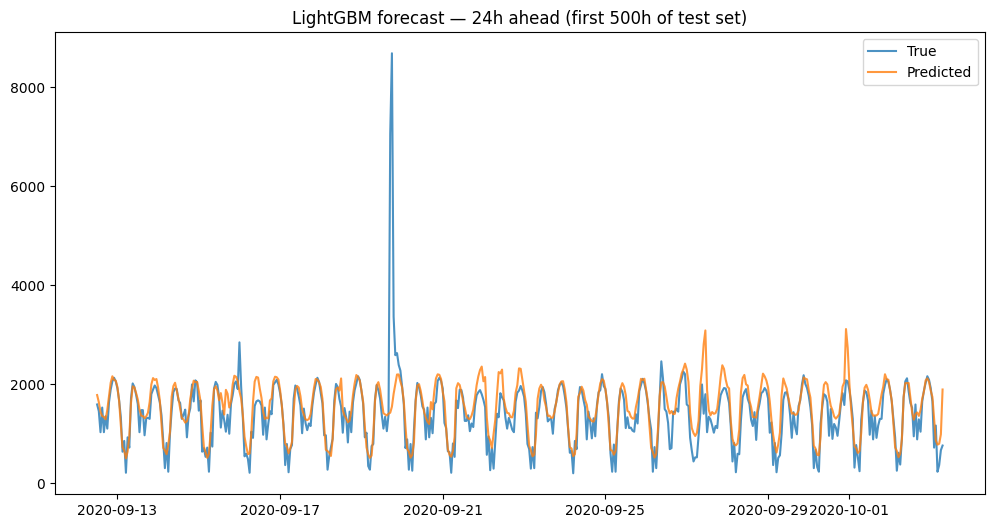

In [167]:
plt.figure(figsize=(12,6))
plt.plot(y_test.index[:500], y_test[:500], label='True', alpha=0.8)
plt.plot(y_test.index[:500], y_pred[:500], label='Predicted', alpha=0.8)
plt.title("LightGBM forecast — 24h ahead (first 500h of test set)")
plt.legend()
plt.show()


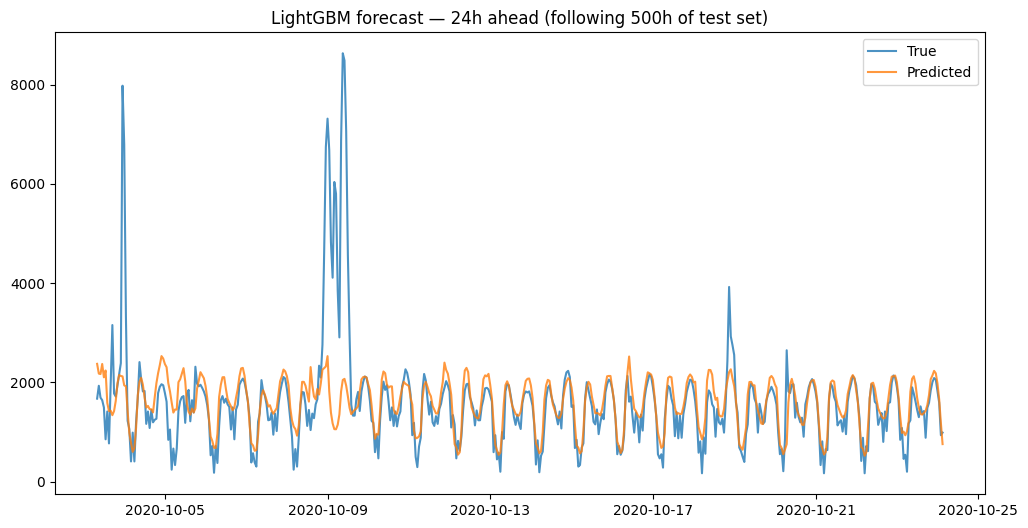

In [168]:
plt.figure(figsize=(12,6))
plt.plot(y_test.index[500:1000], y_test[500:1000], label='True', alpha=0.8)
plt.plot(y_test.index[500:1000], y_pred[500:1000], label='Predicted', alpha=0.8)
plt.title("LightGBM forecast — 24h ahead (following 500h of test set)")
plt.legend()
plt.show()

<div style="border-radius:10px; padding: 15px; background-color:rgb(36, 117, 179); font-size:120%; text-align:left">

We can see that the model learned very successfully the most common values (small oscillations around the mean value). 

However it did not at all predict the peaks, which are likely to be the ones really important to predict.

To find areas for improvement, we will look at feature importance.

<a id="feature"></a>
### <p style="color: rgb(250, 150, 150); font-family:'Futura', 'Century Gothic', 'Verdana', sans-serif; font-weight:600; letter-spacing:0.5px;">Part IV.1.E Feature Importance

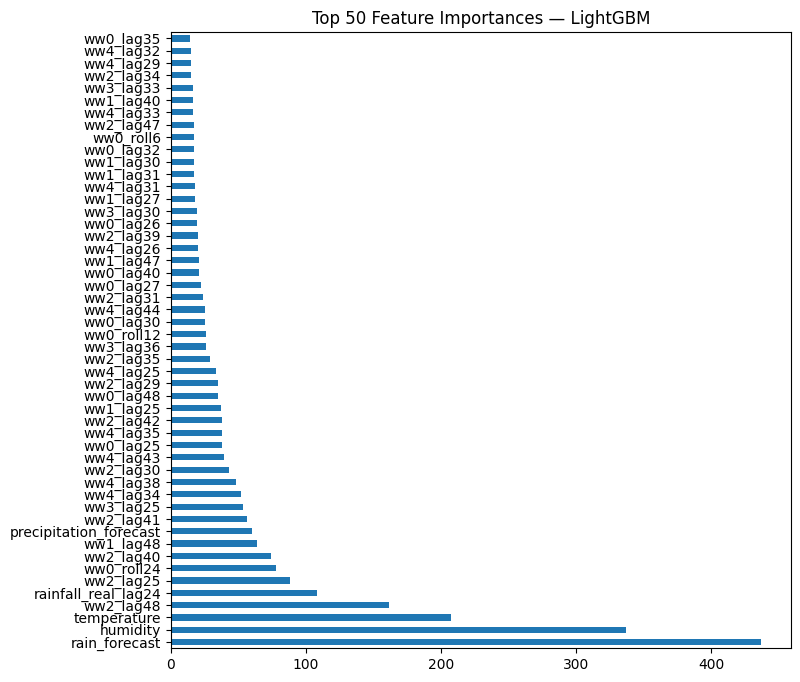

In [169]:
importances = pd.Series(model.feature_importances_, index=features).sort_values(ascending=False)
plt.figure(figsize=(8,8))
importances.head(50).plot(kind='barh')
plt.title("Top 50 Feature Importances — LightGBM")
plt.show()


<div style="border-radius:10px; padding: 15px; background-color:rgb(36, 117, 179); font-size:120%; text-align:left">

To improve the performance and efficiency on the **LightGBM model**, we will be implementing several key optimizations and feature engineering strategies : 

**Focus on Important Features and Reduction of Lags**:  
- We will prioritize the use of **features identified as most important** from the feature importance analysis. This ensures that we focus on the variables that have the highest impact on predicting wastewater volume.
- Only few lags are very important (as shown in the feature importance analysis), so to simplify the model and reduce computational complexity, we will be using **fewer lags**. This helps in making the model lighter and faster while retaining its predictive power.

**Enhanced Feature Engineering**:
- We will have **additional feature engineering** on key meteorological variables such as **rainfall, rain forecast, humidity, and temperature**. (which are shown to be important).

**Incorporation of Autocorrelation Data**:
- We will also add **autocorrelation features**, which we did not really used in the previous version, to better capture the temporal dependencies in the data. These features help the model better understand the patterns and trends in the time series data, leading to more accurate predictions

By combining hyperparameter optimization with thoughtful feature engineering, there is good chance to believe the next version will succed better.

<a id="v2"></a>
# <p style="color:#E71B24; font-family:'Futura', 'Century Gothic', 'Verdana', sans-serif; font-weight:600; letter-spacing:0.5px; text-align:center;">PART V - Improving the LightGBM</p>

<a id="FE_LGBM"></a>
## <p style="color: rgb(300, 110, 110); font-family:'Futura', 'Century Gothic', 'Verdana', sans-serif; font-weight:600; letter-spacing:0.5px;"> Part V.1 Feature Enginerring for LightGBM v.2

In [170]:
LightGBM_v2_df = df.copy()
LightGBM_v2_df

,wastewater volume,ww line 1,ww line 2,ww line 3,ww line 4,rainfall,temperature_2m,relative_humidity_2m,rain,precipitation
date,,,,,,,,,,
2018-07-01 01:00:00,1649.10,238.55,497.84,103.72,808.99,0.0,33.98,56.43,0.0,0.0
2018-07-01 02:00:00,1254.98,155.58,300.78,72.60,726.02,0.0,34.65,56.43,0.0,0.0
2018-07-01 03:00:00,622.30,114.09,186.69,31.12,290.41,0.0,34.24,60.20,0.0,0.0
2018-07-01 04:00:00,694.90,82.97,114.09,20.74,477.10,0.0,32.63,62.80,0.0,0.0
2018-07-01 05:00:00,186.69,62.23,93.35,31.12,0.00,0.0,32.01,62.09,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2021-06-06 19:00:00,1617.99,311.15,425.24,124.46,757.13,0.0,20.96,87.62,0.0,0.0
2021-06-06 20:00:00,1856.53,352.64,539.33,165.95,798.62,0.0,20.70,87.87,0.0,0.0
2021-06-06 21:00:00,1949.88,394.12,591.19,165.95,798.62,0.0,20.91,85.97,0.0,0.0


<a id="model"></a>
### <p style="color: rgb(250, 150, 150); font-family:'Futura', 'Century Gothic', 'Verdana', sans-serif; font-weight:600; letter-spacing:0.5px;">Part V.1.A Target and lags

In [171]:
target_col = "wastewater volume"

#Shift ww to prevent data leakage
LightGBM_v2_df["target_col_24"] = LightGBM_v2_df[target_col].shift(24)
LightGBM_v2_df["ww1_24"] = LightGBM_v2_df["ww line 1"].shift(24)
LightGBM_v2_df["ww2_24"] = LightGBM_v2_df["ww line 2"].shift(24)
LightGBM_v2_df["ww3_24"] = LightGBM_v2_df["ww line 3"].shift(24)
LightGBM_v2_df["ww4_24"] = LightGBM_v2_df["ww line 4"].shift(24)

# Create lag features (we keep only the most relevant lags based on ACF/PACF and feature importance analysis)
for lag in [1, 2, 3, 6, 12, 18, 24, 36, 48]:
    LightGBM_v2_df[f"ww0_lag{lag}"] = LightGBM_v2_df["target_col_24"].shift(lag)
    LightGBM_v2_df[f"ww1_lag{lag}"] = LightGBM_v2_df["ww1_24"].shift(lag)
    LightGBM_v2_df[f"ww2_lag{lag}"] = LightGBM_v2_df["ww2_24"].shift(lag)
    LightGBM_v2_df[f"ww3_lag{lag}"] = LightGBM_v2_df["ww3_24"].shift(lag)
    LightGBM_v2_df[f"ww4_lag{lag}"] = LightGBM_v2_df["ww4_24"].shift(lag)

# Rolling window averages to capture recent trends
for window in [6, 12, 24]:
    LightGBM_v2_df[f"ww0_roll{window}"] = (
        LightGBM_v2_df["target_col_24"].rolling(window=window).mean()
    )
    
# Rolling window averages for ww lines
for window in [6, 12, 24]:
    LightGBM_v2_df[f"humidity_roll{window}"] = (
        LightGBM_v2_df["relative_humidity_2m"].rolling(window=window).mean()
    )


In [172]:
# Shift rainfall to prevent data leakage
LightGBM_v2_df["rainfall_lag24"] = LightGBM_v2_df["rainfall"].shift(24)
LightGBM_v2_df = LightGBM_v2_df.drop(columns=["rainfall"])

# Cumulative rainfall over different periods   
LightGBM_v2_df['rain_cum_6h']  = LightGBM_v2_df['rainfall_lag24'].rolling(6).sum()
LightGBM_v2_df['rain_cum_12h'] = LightGBM_v2_df['rainfall_lag24'].rolling(12).sum()
LightGBM_v2_df['rain_cum_24h'] = LightGBM_v2_df['rainfall_lag24'].rolling(24).sum()

# Cumulative rain over different periods
LightGBM_v2_df['rain_cum_6h']  = LightGBM_v2_df['rain'].rolling(6).sum()
LightGBM_v2_df['rain_cum_12h'] = LightGBM_v2_df['rain'].rolling(12).sum()
LightGBM_v2_df['rain_cum_24h'] = LightGBM_v2_df['rain'].rolling(24).sum()

<a id="model"></a>
### <p style="color: rgb(250, 150, 150); font-family:'Futura', 'Century Gothic', 'Verdana', sans-serif; font-weight:600; letter-spacing:0.5px;">Part V.1.B Autocorrelation based features

In [173]:
# Difference compared to previous day
LightGBM_v2_df["ww0_diff24"] = (
    LightGBM_v2_df["target_col_24"] - LightGBM_v2_df["target_col_24"].shift(24)
)

# Ratio to previous day (stability / abnormal variation)
LightGBM_v2_df["ww0_ratio24"] = (
    LightGBM_v2_df["target_col_24"] / (LightGBM_v2_df["target_col_24"].shift(24) + 1e-6)
)

# Local variation (standard deviation over 12 hours)
LightGBM_v2_df["ww0_std12"] = (
    LightGBM_v2_df["target_col_24"].rolling(window=12).std()
)

# 5. Drop rows with missing values (caused by shifts)
LightGBM_v2_df = LightGBM_v2_df.dropna()

<a id="model"></a>
### <p style="color: rgb(250, 150, 150); font-family:'Futura', 'Century Gothic', 'Verdana', sans-serif; font-weight:600; letter-spacing:0.5px;">Part V.1.C temporal / cyclical features

In [174]:
# Cyclical encoding for hour and day of week
LightGBM_v2_df["hour_sin"] = np.sin(2 * np.pi * LightGBM_v2_df["hour"] / 24)
LightGBM_v2_df["hour_cos"] = np.cos(2 * np.pi * LightGBM_v2_df["hour"] / 24)
LightGBM_v2_df["dow_sin"] = np.sin(2 * np.pi * LightGBM_v2_df["dayofweek"] / 7)
LightGBM_v2_df["dow_cos"] = np.cos(2 * np.pi * LightGBM_v2_df["dayofweek"] / 7)

KeyError: 'hour'

<div style="border-radius:10px; padding: 15px; background-color:rgb(36, 117, 179); font-size:120%; text-align:left">

**hour_sin and hour_cos:** These features use sine and cosine transformations to encode the hour of the day in a cyclical manner. This helps the model understand that hours are part of a continuous cycle (24 hours in a day), avoiding the issue of treating 23:00 and 00:00 as completely different values.
dow_sin and dow_cos: Similarly, these features use sine and cosine transformations to encode the day of the week in a cyclical manner.

This helps the model understand that days of the week are part of a continuous cycle (7 days in a week), avoiding the issue of treating Sunday and Monday as completely different values.

<a id="LGBM2"></a>
## <p style="color: rgb(300, 110, 110); font-family:'Futura', 'Century Gothic', 'Verdana', sans-serif; font-weight:600; letter-spacing:0.5px;"> Part V.2 Implementing the model

<a id="model"></a>
### <p style="color: rgb(250, 150, 150); font-family:'Futura', 'Century Gothic', 'Verdana', sans-serif; font-weight:600; letter-spacing:0.5px;">Part V.2.A Train/test split by shuffled 7-day blocks

<div style="border-radius:10px; padding: 15px; background-color:rgb(36, 117, 179); font-size:120%; text-align:left">

To ensure a robust evaluation of our model while preserving the temporal structure of the data, we implement a block-based train-test split:


**Block Creation:** : We create blocks of data where each block represents a 7-day period. This is done by calculating the number of days since the minimum date in the index and dividing by 7. This ensures that each block contains a full week of data.



**Random Shuffling of Blocks:** We shuffle the unique block IDs randomly to distribute the blocks across the train and test sets. This randomness helps in reducing bias and ensures that the model is evaluated on a representative sample of the data.



**Train-Test Split:** We allocate 80% of the blocks to the training set and 20% of the blocks to the test set. This ensures that the temporal structure of the data is preserved within each set, which is crucial for time series analysis.
train_blocks: The blocks assigned to the training set.
test_blocks: The blocks assigned to the test set.



**Data Segregation:** We filter the original DataFrame to create separate training and testing DataFrames based on the block IDs.
train_df: The DataFrame containing the training data.
test_df: The DataFrame containing the test data.



This block-based approach ensures that the temporal dependencies within the data are respected, providing a more realistic evaluation of the model's performance on unseen data.


In [99]:
# Create a block index (1 block = 7 days)
LightGBM_v2_df["block_id"] = (
    (LightGBM_v2_df.index - LightGBM_v2_df.index.min()).days // 7
)

# Shuffle block IDs randomly
unique_blocks = LightGBM_v2_df["block_id"].unique()
np.random.seed(42)
np.random.shuffle(unique_blocks)

# Define 80% train, 20% test by block
n_train_blocks = int(len(unique_blocks) * 0.8)
train_blocks = unique_blocks[:n_train_blocks]
test_blocks = unique_blocks[n_train_blocks:]

train_df = LightGBM_v2_df[LightGBM_v2_df["block_id"].isin(train_blocks)]
test_df = LightGBM_v2_df[LightGBM_v2_df["block_id"].isin(test_blocks)]

# Drop helper column
train_df = train_df.drop(columns=["block_id"])
test_df = test_df.drop(columns=["block_id"])


<a id="split"></a>
### <p style="color: rgb(250, 150, 150); font-family:'Futura', 'Century Gothic', 'Verdana', sans-serif; font-weight:600; letter-spacing:0.5px;">Part V.2.B Splitting the Data

In [100]:
feature_cols = [
    c for c in LightGBM_v2_df.columns
    if c not in [target_col, "ww line 1", "ww line 2", "ww line 3", "ww line 4","block_id"]
]

X_train = train_df[feature_cols]
y_train = train_df[target_col]
X_test = test_df[feature_cols]
y_test = test_df[target_col]

<a id="split"></a>
### <p style="color: rgb(250, 150, 150); font-family:'Futura', 'Century Gothic', 'Verdana', sans-serif; font-weight:600; letter-spacing:0.5px;">Part V.2.C Finding the hyperparameters

In [101]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

def objective(trial):
    """Objective function for Optuna hyperparameter optimization"""
    params = {
        'num_leaves': trial.suggest_int('num_leaves', 20, 200),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.05, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 100, 800),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'verbose': -1,
        'random_state': 42
    }

    model = LGBMRegressor(**params)
    model.fit(X_train, y_train)
    
    preds = model.predict(X_val)
    mae = mean_absolute_error(y_val, preds)
    return mae

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

In [102]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=40, show_progress_bar=False)

best_params = study.best_params
print(" Best parameters found by Optuna:")
for k, v in best_params.items():
    print(f"  {k}: {v}")

 Best parameters found by Optuna:
  num_leaves: 112
  max_depth: 10
  learning_rate: 0.03008049079913777
  n_estimators: 473
  subsample: 0.8973923498257022
  colsample_bytree: 0.649526090007954


<a id="split"></a>
### <p style="color: rgb(250, 150, 150); font-family:'Futura', 'Century Gothic', 'Verdana', sans-serif; font-weight:600; letter-spacing:0.5px;">Part V.2.D Model and Evaluation

In [103]:
best_model = LGBMRegressor(**best_params, random_state=42, verbose=-1)
best_model.fit(
    np.concatenate([X_train, X_val]),
    np.concatenate([y_train, y_val])
)

LGBMRegressor(colsample_bytree=0.649526090007954,
              learning_rate=0.03008049079913777, max_depth=10, n_estimators=473,
              num_leaves=112, random_state=42, subsample=0.8973923498257022,
              verbose=-1)

In [107]:
y_pred = best_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nModel Evaluation on Test Set:")
print(f"MAE = {mae:.2f}")
print(f"MSE = {mse:.2f}")
print(f"R²  = {r2:.3f}")


Model Evaluation on Test Set:
MAE = 338.42
MSE = 551405.52
R²  = 0.568


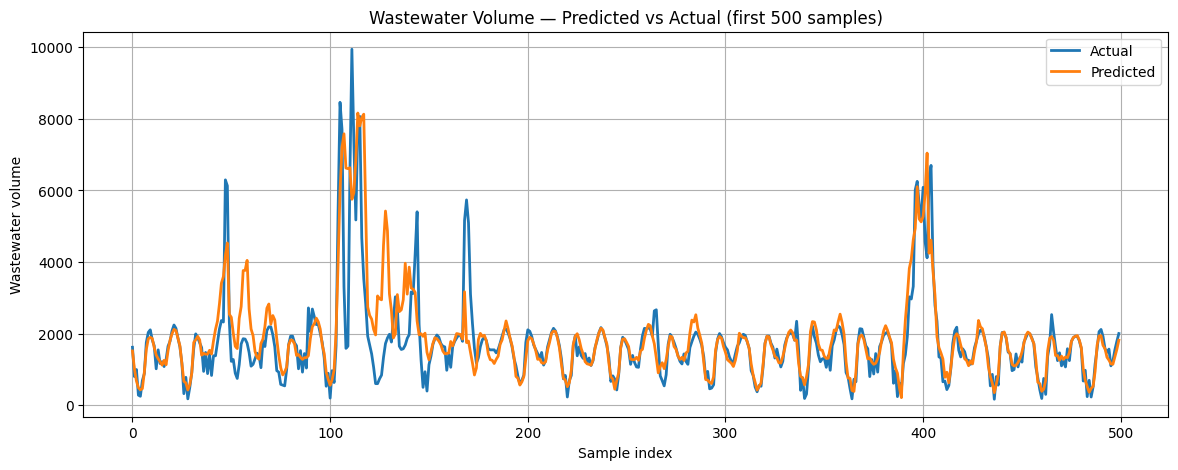

In [105]:
# plotting the prediction

plt.figure(figsize=(14, 5))
plt.plot(y_test.values[:500], label="Actual", linewidth=2)
plt.plot(y_pred[:500], label="Predicted", linewidth=2)
plt.title("Wastewater Volume — Predicted vs Actual (first 500 samples)")
plt.xlabel("Sample index")
plt.ylabel("Wastewater volume")
plt.legend()
plt.grid(True)
plt.show()

<div style="border-radius:10px; padding: 15px; background-color:rgb(36, 117, 179); font-size:120%; text-align:left">

We can see here that the peaks are detected much more accurately by the model.
However, the MAE was lower with the previous model. This one is more “reactive” (or “sensitive”), meaning it tends to oscillate more around small fluctuations, which reduces its point-by-point precision.
But because it captures large variations and extreme values better, its overall R² score is higher.

Overall, I htink this model is likely more useful for real-world forecasting, as accurately anticipating major peaks is probably more valuable than achieving very high precision on minor fluctuations.

<a id="setup"></a>
# <p style="color:#E71B24; font-family:'Futura', 'Century Gothic', 'Verdana', sans-serif; font-weight:600; letter-spacing:0.5px; text-align:center;">PART VII - Testing a more advanced model using Deep Learning - Ts2Vec</p>

<div style="border-radius:10px; padding: 15px; background-color:rgb(36, 117, 179); font-size:120%; text-align:left">

In this final step, we will examine a more advanced model that directly addresses a challenge we identified earlier: the presence of multiple phenomena evolving across different temporal scales.  

Since the data contains both short-term fluctuations and long-term structural patterns, the key objective is to learn a **contextual, multi-scale temporal representation** of the features. This also naturally supports the **multivariate nature** of the problem (ww1 + ww2 + ww3 + ww4), allowing the model to encode how variables interact and evolve together over time.

What makes this approach particularly appealing is its ability to capture **complex, evolving dynamics** at several temporal resolutions simultaneously. The model is designed to encode both local variations and global trends, providing a richer and more expressive understanding of temporal behavior than traditional architectures.

The idea comes from this paper [https://arxiv.org/abs/2106.10466](https://arxiv.org/abs/2106.10466) — which provides both the theoretical foundations and a ready-to-use implementation. Given its relevance and the availability of the code, testing this model became a compelling choice for our experiments.

Moreover, the original paper describes not only how to build such representations, but also how to use them for robust forecasting tasks. Across many datasets, the proposed method achieves **state-of-the-art results**, demonstrating strong generalization and predictive power.


<a id="FE_LGBM"></a>
## <p style="color: rgb(300, 110, 110); font-family:'Futura', 'Century Gothic', 'Verdana', sans-serif; font-weight:600; letter-spacing:0.5px;"> Part VII.1 Preparing the Data

In [158]:
ts2vec_df = df.copy()

In [159]:
# resample df into daily_df taking 24 entry and averaging them into one daily entry
ts2vec_df.index.name = 'date'               # give the index a name so reset_index yields 'date'
daily_df = ts2vec_df.resample('D').mean()
daily_df.reset_index(inplace=True)

In [160]:
daily_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1072 entries, 0 to 1071
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   date                  1072 non-null   datetime64[ns]
 1   wastewater volume     1072 non-null   float64       
 2   ww line 1             1072 non-null   float64       
 3   ww line 2             1072 non-null   float64       
 4   ww line 3             1072 non-null   float64       
 5   ww line 4             1072 non-null   float64       
 6   rainfall              1072 non-null   float64       
 7   temperature_2m        1072 non-null   float64       
 8   relative_humidity_2m  1072 non-null   float64       
 9   rain                  1072 non-null   float64       
 10  precipitation         1072 non-null   float64       
dtypes: datetime64[ns](1), float64(10)
memory usage: 92.3 KB


In [10]:
#split train and test set with 2/3 and 1/3 of the data
n = len(ts2vec_df)
train_size = int(n * (2/3))
train_df = ts2vec_df[:train_size]
test_df = ts2vec_df[train_size:]

print(f"Train set shape: {train_df.shape}")
print(f"Test set shape: {test_df.shape}")

Train set shape: (17151, 10)
Test set shape: (8576, 10)


In [11]:
print(train_df.columns)

Index(['wastewater volume', 'ww line 1', 'ww line 2', 'ww line 3', 'ww line 4',
       'rainfall', 'temperature_2m', 'relative_humidity_2m', 'rain',
       'precipitation'],
      dtype='object')


In [12]:
# remove "wastewater volume" from train and test set
train_df = train_df.drop(columns=['wastewater volume'])
test_df = test_df.drop(columns=['wastewater volume'])


# add a dimesion to train and test set to make them 3D (samples, timesteps, features)
train_data = np.expand_dims(train_df.values, axis=0)
test_data = np.expand_dims(test_df.values, axis=0)


In [13]:
print("train_data shape:", np.array(train_data).shape)
print("test_data shape:", np.array(test_data).shape)

train_data shape: (1, 17151, 9)
test_data shape: (1, 8576, 9)


<a id="FE_LGBM"></a>
## <p style="color: rgb(300, 110, 110); font-family:'Futura', 'Century Gothic', 'Verdana', sans-serif; font-weight:600; letter-spacing:0.5px;"> Part VII.2 Implementing the model 

<a id="new_dataframe"></a>
### <p style="color: rgb(250, 150, 150); font-family:'Futura', 'Century Gothic', 'Verdana', sans-serif; font-weight:600; letter-spacing:0.5px;"> Part VII.2.A Training ts2vec

In [ ]:
# train TS2Vec model on train set


model = TS2Vec(
    input_dims=train_data.shape[2],
    device='cuda' if torch.cuda.is_available() else 'cpu',
    max_train_length=500
)


In [15]:
loss_log = model.fit(
    train_data,
    verbose=True
)

Epoch #0: loss=5011328.875
Epoch #1: loss=1051119.03125
Epoch #2: loss=750581.96875
Epoch #3: loss=519435.53125
Epoch #4: loss=259819.375
Epoch #5: loss=203682.6953125
Epoch #6: loss=146179.6015625
Epoch #7: loss=102421.046875
Epoch #8: loss=100518.64453125
Epoch #9: loss=108667.59765625
Epoch #10: loss=81524.453125
Epoch #11: loss=64646.4765625
Epoch #12: loss=58126.94921875
Epoch #13: loss=47467.2265625
Epoch #14: loss=47938.79296875
Epoch #15: loss=44357.775390625
Epoch #16: loss=37023.205078125
Epoch #17: loss=37657.865234375
Epoch #18: loss=30089.580078125
Epoch #19: loss=31167.060546875
Epoch #20: loss=29045.5400390625
Epoch #21: loss=22742.671875
Epoch #22: loss=23435.6650390625
Epoch #23: loss=25407.6591796875
Epoch #24: loss=18953.0859375
Epoch #25: loss=20175.3505859375
Epoch #26: loss=17679.9521484375
Epoch #27: loss=16002.861328125
Epoch #28: loss=15112.982421875
Epoch #29: loss=14639.61865234375
Epoch #30: loss=12947.8056640625
Epoch #31: loss=12687.8095703125
Epoch #32: l

In [16]:
train_repr = model.encode(train_data,causal=True)

In [17]:
test_repr = model.encode(test_data,causal=True)

In [18]:
print(train_repr.shape)

(1, 17151, 320)


<a id="new_dataframe"></a>
### <p style="color: rgb(250, 150, 150); font-family:'Futura', 'Century Gothic', 'Verdana', sans-serif; font-weight:600; letter-spacing:0.5px;"> Part VII.2.B Linear regression model on the encoded train set

In [19]:
# we are going to train a simple linear regression model on the test set repr to predict the 4 ww lines

X_train = []
y_train = []

post_len=24

for i in range(0, train_repr.shape[1] - post_len,1):
    X_train.append(np.concatenate((train_repr[0, i].flatten(), train_df.iloc[i:i + post_len][["temperature_2m","rain","relative_humidity_2m"]].values.flatten())))
    y_train.append(train_df.iloc[i:i + post_len][['ww line 1', 'ww line 2', 'ww line 3', 'ww line 4']].values.flatten())

In [ ]:
reg = LinearRegression()
reg.fit(X_train, y_train)

LinearRegression()

<a id="new_dataframe"></a>
### <p style="color: rgb(250, 150, 150); font-family:'Futura', 'Century Gothic', 'Verdana', sans-serif; font-weight:600; letter-spacing:0.5px;"> Part VII.2.C Evalution of the model

In [24]:
# evaluate on test set
X_test = []
y_test = []
for i in range(1, test_repr.shape[1] - post_len,25):
    X_test.append(np.concatenate((test_repr[0, i].flatten(), test_df.iloc[i:i + post_len][["temperature_2m","rain","relative_humidity_2m"]].values.flatten())))
    y_test.append(test_df.iloc[i:i + post_len][['ww line 1', 'ww line 2', 'ww line 3', 'ww line 4']].values.flatten())


In [ ]:
y_pred = reg.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Test MSE: {mse}")

Test MSE: 51494.59710269786


In [27]:
print("y_test shape:", np.array(y_test).shape)

y_test shape: (343, 96)


<a id="new_dataframe"></a>
### <p style="color: rgb(250, 150, 150); font-family:'Futura', 'Century Gothic', 'Verdana', sans-serif; font-weight:600; letter-spacing:0.5px;"> Part VII.2.D Recreating the wastewater volume feature to plot the results

In [ ]:
# reacreate the feature wastewater (juste divide the 96 values in 4 clusters and sum them)
y_test_sum = np.sum(np.array(y_test).reshape(-1, 24, 4), axis=2)
y_pred_sum = np.sum(y_pred.reshape(-1, 24, 4), axis=2)

In [30]:
#compute mse on the sum,R2score,MAE
mse_sum = mean_squared_error(y_test_sum, y_pred_sum)
r2 = r2_score(y_test_sum, y_pred_sum)
mae = mean_absolute_error(y_test_sum, y_pred_sum)
print(f"Test MSE on sum: {mse_sum}")
print(f"Test R2 score on sum: {r2}")
print(f"Test MAE on sum: {mae}")

Test MSE on sum: 366058.7628940156
Test R2 score on sum: 0.6542881794885488
Test MAE on sum: 315.84069488720746


In [31]:
#shape of y_test_sum
print("y_test_sum shape:", y_test_sum.shape)

y_test_sum shape: (343, 24)


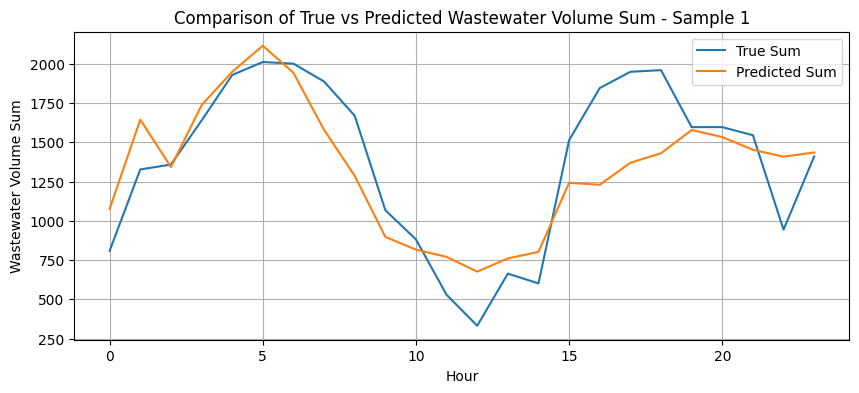

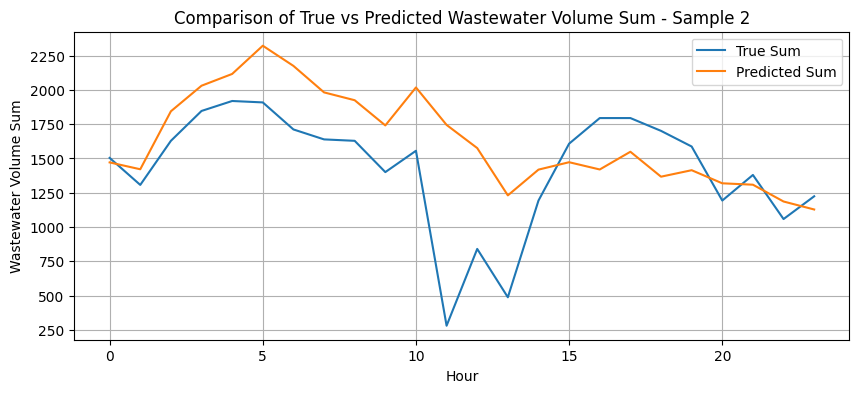

In [ ]:
#compare true vs predicted sum over test set
N=2
for i in range(N):
    plt.figure(figsize=(10, 4))
    plt.plot(y_test_sum[i], label='True Sum')
    plt.plot(y_pred_sum[i], label='Predicted Sum')
    plt.title(f'Comparison of True vs Predicted Wastewater Volume Sum - Sample {i+1}')
    plt.xlabel('Hour')
    plt.ylabel('Wastewater Volume Sum')
    plt.legend()
    plt.grid()
    plt.show()

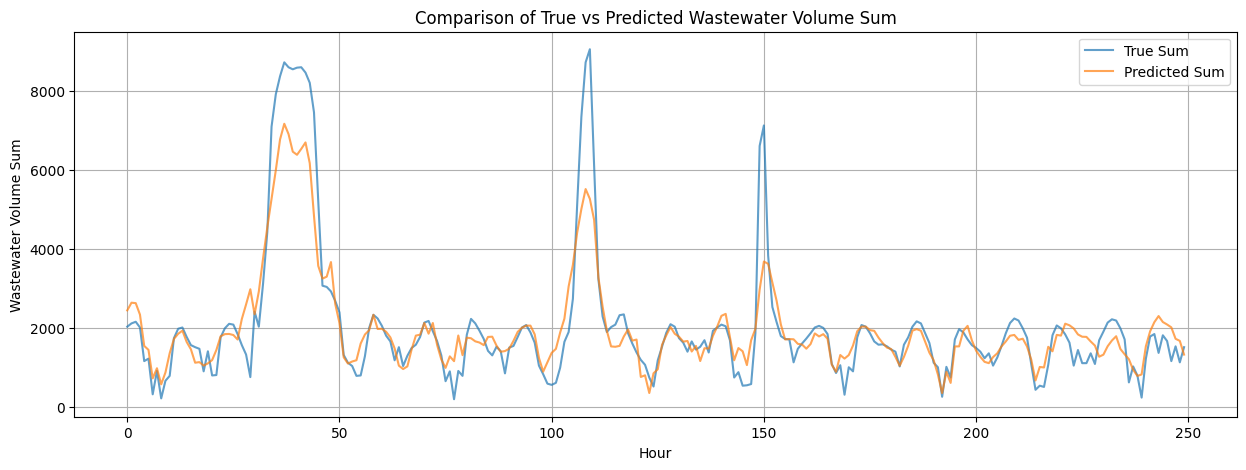

In [ ]:
y_pred = np.concatenate(y_pred_sum, axis=0)
y_test = np.concatenate(y_test_sum, axis=0)

N=250
i=50
plt.figure(figsize=(15, 5))
plt.plot(y_test[i:i+N], label='True Sum', alpha=0.7)
plt.plot(y_pred[i:i+N], label='Predicted Sum', alpha=0.7)
plt.title('Comparison of True vs Predicted Wastewater Volume Sum')
plt.xlabel('Hour')
plt.ylabel('Wastewater Volume Sum')
plt.legend()
plt.grid()
plt.show()

<div style="border-radius:10px; padding: 15px; background-color:rgb(36, 117, 179); font-size:120%; text-align:left">
In conclusion, this project allowed me to familiarize myself with an example of what an industrial prediction project at Veolia might look like. 

This dataset was very rich and therefore particularly interesting to explore and try to understand in depth. It also allowed me to do some research and discover new models. However, there are still several avenues that I did not have time to explore sufficiently, such as ARIMA statistical models, which are widely used in time series but which I found complicated to configure in order to understand a problem of this complexity (requiring a multi-scale temporal approach). 

Finally, in a project of this type, compromises may have to be made (such as choosing between a model that is more accurate for small variations or one that better detects peaks, see light GBM 1 and 2), and in this case, regular contact with the project's sponsoring teams would be particularly useful, which was not possible in this project.
